In [1]:
from IPython.core.debugger import set_trace

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot_ng as pydot


import sys
sys.path.append('../financial_utils/')

import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

import performance as per

C:\Users\Jon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# DATASET

### Load and Compute Returns

In [2]:
price_table = pd.read_csv('history_files/^GSPC.csv')
vol_table = pd.read_csv('history_files/VIX.csv')

# Build Tick Table
tick_table = price_table[["Date","Close"]]
tick_table.columns = ["Date", "Tick"]
# Get Return Table
returns = per.tick2ret(tick_table)
returns_table = pd.DataFrame({'Date':tick_table.Date[1:], 'Return': returns[:,0]})
returns_table = returns_table.set_index('Date')
# Drop columns of Vol Table
vol_table = vol_table[["Date", "Close"]]
vol_table.columns = ["Date", "Vol"]
vol_table.Vol = vol_table.Vol/100
vol_table = vol_table.set_index('Date')
# InnerJoin
retvol_table = pd.concat([returns_table,vol_table], join='inner', axis=1)


In [3]:
T_x = 10
n_fields = 2
T_y = 3
T_stride = 1

### Generate Dataset

In [4]:
def gen_dataset(T_x, T_y, n_fields, T_stride, retvol_table):
    """
    
    
    return
        x E (m, T_x)
        y E (m, T_y)
    """
    
    m = int(np.floor((returns.shape[0] - T_x) / T_stride))
    
    x = np.nan * np.ones((m-T_y*T_stride, T_x, n_fields))
    y = np.nan * np.ones((m-T_y*T_stride, T_y, n_fields))
    
    for i in range(m-T_y*T_stride):
        x[i,:,0] = retvol_table.Return[i*T_stride:i*T_stride+T_x].transpose()
        x[i,:,1] = retvol_table.Vol[i*T_stride:i*T_stride+T_x].transpose()
        y[i,:,0] = retvol_table.Return[i*T_stride+T_x:i*T_stride+T_x+T_y].transpose()
        y[i,:,1] = retvol_table.Vol[i*T_stride+T_x:i*T_stride+T_x+T_y].transpose()

    return x, y, m

In [5]:
def normalize_data(x, params=None):
    """
    
    return 
        x_norm
        x_norm_param = (mean, std)
    """
    if params == None:
        mean = np.mean(x, axis=(0,1)) 
        std = np.std(x, axis=(0,1))
    else:
        mean = params[0]
        std = params[1]
    x_norm_param = (mean, std)
    x_norm = (x - mean)/std
    
    return x_norm, x_norm_param

In [6]:
def denormalize_data(x_norm, x_norm_param):
    """"""
    
    mean = x_norm_param[0]
    std = x_norm_param[1]
    x = x_norm * std + mean
    
    return x

In [7]:
x, y, m = gen_dataset(T_x,T_y, n_fields, T_stride,retvol_table)
x, x_norm_param = normalize_data(x)
y, _ = normalize_data(y, x_norm_param)
print('Training Example: '+str(m))
print('X Shape: '+str(x.shape))
print('Y Shape: '+str(y.shape))

Training Example: 6085
X Shape: (6082, 10, 2)
Y Shape: (6082, 3, 2)


### Train / Val / Test

In [8]:
x,y = shuffle(x,y)

train_end = int(m * 0.7)

val_end = train_end + int(0.15 * m)

x_train = x[0:train_end]
x_val = x[train_end:val_end]
x_test = x[val_end:]

y_train = y[0:train_end]
y_val = y[train_end:val_end]
y_test = y[val_end:]

# Keras Model

### Encoder- Decoder

In [28]:
keras.backend.clear_session()

n_a = 100

encoder_LSTM = keras.layers.LSTM(units = n_a, return_state=True)
decoder_LSTM = keras.layers.LSTM(units = n_a, return_state=True, return_sequences=True)

flatter = keras.layers.Flatten()
dense = keras.layers.Dense(units = 100, activation='tanh')
relu_out = keras.layers.Dense(units = n_fields, activation='tanh')
concatenator = keras.layers.Lambda(lambda x: keras.backend.stack(x, axis=1))
last_slicor = keras.layers.Lambda(lambda x: x[:,-2:-1,:])

In [29]:
def define_model(T_x, T_y, n_fields, n_a):
    
    x_input = keras.layers.Input(shape=(T_x, n_fields))
    output_seq = list()
    
    _, encoder_h, encoder_c = encoder_LSTM(x_input)  
    
    decoder_input = keras.layers.Input(shape=(1,n_a))
    deco_input = decoder_input
    decoder_h = encoder_h
    decoder_c = encoder_c
    
    for _ in range(T_y):
        decoder_outputs, decoder_h, decoder_c = decoder_LSTM(deco_input, initial_state=[decoder_h, decoder_c])
        decoder_outputs_flat = flatter(decoder_outputs)
        out = dense(decoder_outputs_flat)
        out = relu_out(out)
        
        output_seq.append(out)
        deco_input = decoder_outputs
        
    output_seq = concatenator(output_seq)
    model = keras.models.Model(inputs=[x_input, decoder_input], outputs=output_seq)
    return model

In [30]:
model = define_model(T_x, T_y, n_fields, n_a)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 2)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 100)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100), (None, 41200       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 1, 100), (No 80400       input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [31]:
optim = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

In [32]:
decoder_in = np.zeros((x_train.shape[0],1,n_a))
decoder_val = np.zeros((x_val.shape[0],1,n_a))
history = model.fit(x=[x_train,decoder_in], y=y_train,
          validation_data = ([x_val, decoder_val], y_val),
          shuffle=True, epochs = 10000)

Train on 4259 samples, validate on 912 samples
Epoch 1/10000
4259/4259 [==============================] - 6s 1ms/step - loss: 0.6921 - acc: 0.7567 - val_loss: 0.6104 - val_acc: 0.7664
Epoch 2/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.6833 - acc: 0.7557 - val_loss: 0.6102 - val_acc: 0.7675
Epoch 3/10000
4259/4259 [==============================] - 2s 484us/step - loss: 0.6818 - acc: 0.7573 - val_loss: 0.6088 - val_acc: 0.7635
Epoch 4/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.6812 - acc: 0.7567 - val_loss: 0.6117 - val_acc: 0.7632
Epoch 5/10000
4259/4259 [==============================] - 2s 496us/step - loss: 0.6819 - acc: 0.7575 - val_loss: 0.6086 - val_acc: 0.7661
Epoch 6/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.6780 - acc: 0.7583 - val_loss: 0.6098 - val_acc: 0.7628
Epoch 7/10000
4259/4259 [==============================] - 2s 491us/step - loss: 0.6777 - acc: 0.7593 - val_loss: 0.6088 

4259/4259 [==============================] - 2s 489us/step - loss: 0.5522 - acc: 0.7660 - val_loss: 0.6059 - val_acc: 0.7606
Epoch 60/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.5512 - acc: 0.7661 - val_loss: 0.6105 - val_acc: 0.7540
Epoch 61/10000
4259/4259 [==============================] - 2s 500us/step - loss: 0.5499 - acc: 0.7684 - val_loss: 0.6136 - val_acc: 0.7624
Epoch 62/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.5461 - acc: 0.7683 - val_loss: 0.6098 - val_acc: 0.7588
Epoch 63/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.5424 - acc: 0.7710 - val_loss: 0.6085 - val_acc: 0.7507
Epoch 64/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.5388 - acc: 0.7707 - val_loss: 0.6279 - val_acc: 0.7544
Epoch 65/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.5426 - acc: 0.7719 - val_loss: 0.6238 - val_acc: 0.7522
Epoch 66/10000
4259/4259 [=========

4259/4259 [==============================] - 2s 491us/step - loss: 0.4275 - acc: 0.8569 - val_loss: 0.6819 - val_acc: 0.7383
Epoch 118/10000
4259/4259 [==============================] - 2s 494us/step - loss: 0.4200 - acc: 0.8614 - val_loss: 0.6725 - val_acc: 0.7438
Epoch 119/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.4177 - acc: 0.8601 - val_loss: 0.6767 - val_acc: 0.7423
Epoch 120/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.4163 - acc: 0.8644 - val_loss: 0.6796 - val_acc: 0.7471
Epoch 121/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.4139 - acc: 0.8672 - val_loss: 0.6677 - val_acc: 0.7361
Epoch 122/10000
4259/4259 [==============================] - 2s 494us/step - loss: 0.4117 - acc: 0.8693 - val_loss: 0.6871 - val_acc: 0.7361
Epoch 123/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.4100 - acc: 0.8716 - val_loss: 0.6853 - val_acc: 0.7350
Epoch 124/10000
4259/4259 [==

4259/4259 [==============================] - 2s 486us/step - loss: 0.3502 - acc: 0.9213 - val_loss: 0.7188 - val_acc: 0.7193
Epoch 176/10000
4259/4259 [==============================] - 2s 500us/step - loss: 0.3493 - acc: 0.9249 - val_loss: 0.7240 - val_acc: 0.7186
Epoch 177/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3496 - acc: 0.9228 - val_loss: 0.7213 - val_acc: 0.7175
Epoch 178/10000
4259/4259 [==============================] - 2s 484us/step - loss: 0.3478 - acc: 0.9258 - val_loss: 0.7200 - val_acc: 0.7164
Epoch 179/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3477 - acc: 0.9231 - val_loss: 0.7279 - val_acc: 0.7080
Epoch 180/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3470 - acc: 0.9228 - val_loss: 0.7205 - val_acc: 0.7127
Epoch 181/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3453 - acc: 0.9309 - val_loss: 0.7288 - val_acc: 0.7083
Epoch 182/10000
4259/4259 [==

4259/4259 [==============================] - 2s 468us/step - loss: 0.3222 - acc: 0.9498 - val_loss: 0.7420 - val_acc: 0.7021
Epoch 234/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3224 - acc: 0.9475 - val_loss: 0.7398 - val_acc: 0.7091
Epoch 235/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3219 - acc: 0.9485 - val_loss: 0.7403 - val_acc: 0.7010
Epoch 236/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3230 - acc: 0.9458 - val_loss: 0.7351 - val_acc: 0.7054
Epoch 237/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3225 - acc: 0.9480 - val_loss: 0.7340 - val_acc: 0.7080
Epoch 238/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3229 - acc: 0.9476 - val_loss: 0.7389 - val_acc: 0.6988
Epoch 239/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3214 - acc: 0.9510 - val_loss: 0.7391 - val_acc: 0.7098
Epoch 240/10000
4259/4259 [==

4259/4259 [==============================] - 2s 469us/step - loss: 0.3170 - acc: 0.9540 - val_loss: 0.7287 - val_acc: 0.7047
Epoch 292/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3219 - acc: 0.9473 - val_loss: 0.7237 - val_acc: 0.7061
Epoch 293/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3176 - acc: 0.9513 - val_loss: 0.7219 - val_acc: 0.7061
Epoch 294/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3158 - acc: 0.9577 - val_loss: 0.7274 - val_acc: 0.7113
Epoch 295/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3154 - acc: 0.9584 - val_loss: 0.7309 - val_acc: 0.7036
Epoch 296/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3156 - acc: 0.9573 - val_loss: 0.7307 - val_acc: 0.7061
Epoch 297/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3155 - acc: 0.9583 - val_loss: 0.7278 - val_acc: 0.7142
Epoch 298/10000
4259/4259 [==

4259/4259 [==============================] - 2s 478us/step - loss: 0.3115 - acc: 0.9697 - val_loss: 0.7282 - val_acc: 0.7127
Epoch 350/10000
4259/4259 [==============================] - 2s 481us/step - loss: 0.3112 - acc: 0.9729 - val_loss: 0.7305 - val_acc: 0.7036
Epoch 351/10000
4259/4259 [==============================] - 2s 555us/step - loss: 0.3113 - acc: 0.9695 - val_loss: 0.7298 - val_acc: 0.7069
Epoch 352/10000
4259/4259 [==============================] - 2s 536us/step - loss: 0.3120 - acc: 0.9663 - val_loss: 0.7306 - val_acc: 0.7076
Epoch 353/10000
4259/4259 [==============================] - ETA: 0s - loss: 0.3152 - acc: 0.966 - 2s 492us/step - loss: 0.3124 - acc: 0.9663 - val_loss: 0.7312 - val_acc: 0.7098
Epoch 354/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3129 - acc: 0.9644 - val_loss: 0.7302 - val_acc: 0.7021
Epoch 355/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3136 - acc: 0.9645 - val_loss: 0.7295 - val_acc

Epoch 407/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3128 - acc: 0.9620 - val_loss: 0.7180 - val_acc: 0.7061
Epoch 408/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3123 - acc: 0.9643 - val_loss: 0.7196 - val_acc: 0.7102
Epoch 409/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3117 - acc: 0.9651 - val_loss: 0.7158 - val_acc: 0.7069
Epoch 410/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3120 - acc: 0.9659 - val_loss: 0.7129 - val_acc: 0.7113
Epoch 411/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3124 - acc: 0.9614 - val_loss: 0.7151 - val_acc: 0.7120
Epoch 412/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3119 - acc: 0.9653 - val_loss: 0.7161 - val_acc: 0.7102
Epoch 413/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3116 - acc: 0.9663 - val_loss: 0.7162 - val_acc: 0.7142
Epoch 414/100

4259/4259 [==============================] - 2s 478us/step - loss: 0.3104 - acc: 0.9695 - val_loss: 0.7108 - val_acc: 0.7145
Epoch 466/10000
4259/4259 [==============================] - 2s 483us/step - loss: 0.3107 - acc: 0.9679 - val_loss: 0.7156 - val_acc: 0.7171
Epoch 467/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3108 - acc: 0.9677 - val_loss: 0.7126 - val_acc: 0.7189
Epoch 468/10000
4259/4259 [==============================] - 2s 483us/step - loss: 0.3108 - acc: 0.9674 - val_loss: 0.7109 - val_acc: 0.7156
Epoch 469/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3108 - acc: 0.9668 - val_loss: 0.7135 - val_acc: 0.7145
Epoch 470/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3109 - acc: 0.9646 - val_loss: 0.7156 - val_acc: 0.7153
Epoch 471/10000
4259/4259 [==============================] - 2s 493us/step - loss: 0.3104 - acc: 0.9693 - val_loss: 0.7099 - val_acc: 0.7135
Epoch 472/10000
4259/4259 [==

4259/4259 [==============================] - 2s 477us/step - loss: 0.3091 - acc: 0.9710 - val_loss: 0.7054 - val_acc: 0.7175
Epoch 524/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3090 - acc: 0.9735 - val_loss: 0.7072 - val_acc: 0.7215
Epoch 525/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3155 - acc: 0.9584 - val_loss: 0.7178 - val_acc: 0.7189
Epoch 526/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3308 - acc: 0.9393 - val_loss: 0.7184 - val_acc: 0.7182
Epoch 527/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3299 - acc: 0.9429 - val_loss: 0.7170 - val_acc: 0.7175
Epoch 528/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3171 - acc: 0.9561 - val_loss: 0.7043 - val_acc: 0.7164
Epoch 529/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3113 - acc: 0.9690 - val_loss: 0.7047 - val_acc: 0.7164
Epoch 530/10000
4259/4259 [==

4259/4259 [==============================] - 2s 477us/step - loss: 0.3096 - acc: 0.9685 - val_loss: 0.7039 - val_acc: 0.7200
Epoch 582/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3092 - acc: 0.9715 - val_loss: 0.7017 - val_acc: 0.7193
Epoch 583/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3089 - acc: 0.9720 - val_loss: 0.7054 - val_acc: 0.7222
Epoch 584/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3088 - acc: 0.9746 - val_loss: 0.7014 - val_acc: 0.7193
Epoch 585/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3086 - acc: 0.9727 - val_loss: 0.7005 - val_acc: 0.7230
Epoch 586/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3087 - acc: 0.9740 - val_loss: 0.7029 - val_acc: 0.7204
Epoch 587/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3100 - acc: 0.9688 - val_loss: 0.7055 - val_acc: 0.7211
Epoch 588/10000
4259/4259 [==

4259/4259 [==============================] - 2s 478us/step - loss: 0.3102 - acc: 0.9701 - val_loss: 0.6992 - val_acc: 0.7189
Epoch 640/10000
4259/4259 [==============================] - 2s 492us/step - loss: 0.3084 - acc: 0.9756 - val_loss: 0.6985 - val_acc: 0.7255
Epoch 641/10000
4259/4259 [==============================] - 2s 480us/step - loss: 0.3076 - acc: 0.9793 - val_loss: 0.6997 - val_acc: 0.7197
Epoch 642/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3073 - acc: 0.9816 - val_loss: 0.7004 - val_acc: 0.7215
Epoch 643/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3073 - acc: 0.9823 - val_loss: 0.6996 - val_acc: 0.7200
Epoch 644/10000
4259/4259 [==============================] - 2s 483us/step - loss: 0.3073 - acc: 0.9820 - val_loss: 0.7002 - val_acc: 0.7215
Epoch 645/10000
4259/4259 [==============================] - 2s 505us/step - loss: 0.3072 - acc: 0.9823 - val_loss: 0.7011 - val_acc: 0.7219
Epoch 646/10000
4259/4259 [==

Epoch 697/10000
4259/4259 [==============================] - 2s 498us/step - loss: 0.3092 - acc: 0.9705 - val_loss: 0.6959 - val_acc: 0.7219
Epoch 698/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3085 - acc: 0.9726 - val_loss: 0.6963 - val_acc: 0.7251
Epoch 699/10000
4259/4259 [==============================] - 2s 497us/step - loss: 0.3079 - acc: 0.9752 - val_loss: 0.6916 - val_acc: 0.7211
Epoch 700/10000
4259/4259 [==============================] - 2s 494us/step - loss: 0.3074 - acc: 0.9775 - val_loss: 0.6939 - val_acc: 0.7208
Epoch 701/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3072 - acc: 0.9771 - val_loss: 0.6921 - val_acc: 0.7186
Epoch 702/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3072 - acc: 0.9776 - val_loss: 0.6947 - val_acc: 0.7215
Epoch 703/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3072 - acc: 0.9791 - val_loss: 0.6937 - val_acc: 0.7244
Epoch 704/100

4259/4259 [==============================] - 2s 485us/step - loss: 0.3153 - acc: 0.9609 - val_loss: 0.6889 - val_acc: 0.7215
Epoch 756/10000
4259/4259 [==============================] - 2s 496us/step - loss: 0.3197 - acc: 0.9537 - val_loss: 0.6878 - val_acc: 0.7230
Epoch 757/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3128 - acc: 0.9644 - val_loss: 0.6895 - val_acc: 0.7281
Epoch 758/10000
4259/4259 [==============================] - 2s 483us/step - loss: 0.3111 - acc: 0.9684 - val_loss: 0.6925 - val_acc: 0.7230
Epoch 759/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3114 - acc: 0.9672 - val_loss: 0.6938 - val_acc: 0.7200
Epoch 760/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3085 - acc: 0.9726 - val_loss: 0.6854 - val_acc: 0.7211
Epoch 761/10000
4259/4259 [==============================] - 2s 496us/step - loss: 0.3073 - acc: 0.9766 - val_loss: 0.6873 - val_acc: 0.7233
Epoch 762/10000
4259/4259 [==

4259/4259 [==============================] - 2s 485us/step - loss: 0.3078 - acc: 0.9735 - val_loss: 0.6822 - val_acc: 0.7262
Epoch 814/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3080 - acc: 0.9744 - val_loss: 0.6815 - val_acc: 0.7255
Epoch 815/10000
4259/4259 [==============================] - 2s 484us/step - loss: 0.3077 - acc: 0.9723 - val_loss: 0.6804 - val_acc: 0.7277
Epoch 816/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3073 - acc: 0.9773 - val_loss: 0.6813 - val_acc: 0.7303
Epoch 817/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3070 - acc: 0.9799 - val_loss: 0.6799 - val_acc: 0.7284
Epoch 818/10000
4259/4259 [==============================] - 2s 498us/step - loss: 0.3068 - acc: 0.9798 - val_loss: 0.6788 - val_acc: 0.7219
Epoch 819/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3069 - acc: 0.9797 - val_loss: 0.6787 - val_acc: 0.7233
Epoch 820/10000
4259/4259 [==

4259/4259 [==============================] - 2s 487us/step - loss: 0.3074 - acc: 0.9782 - val_loss: 0.6848 - val_acc: 0.7248
Epoch 872/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3073 - acc: 0.9797 - val_loss: 0.6840 - val_acc: 0.7237
Epoch 873/10000
4259/4259 [==============================] - 2s 490us/step - loss: 0.3072 - acc: 0.9794 - val_loss: 0.6847 - val_acc: 0.7237
Epoch 874/10000
4259/4259 [==============================] - 2s 497us/step - loss: 0.3071 - acc: 0.9804 - val_loss: 0.6852 - val_acc: 0.7251
Epoch 875/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3070 - acc: 0.9813 - val_loss: 0.6857 - val_acc: 0.7255
Epoch 876/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3070 - acc: 0.9805 - val_loss: 0.6862 - val_acc: 0.7266
Epoch 877/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3069 - acc: 0.9816 - val_loss: 0.6862 - val_acc: 0.7251
Epoch 878/10000
4259/4259 [==

4259/4259 [==============================] - 2s 470us/step - loss: 0.3072 - acc: 0.9786 - val_loss: 0.6872 - val_acc: 0.7230
Epoch 930/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3073 - acc: 0.9789 - val_loss: 0.6874 - val_acc: 0.7248
Epoch 931/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3073 - acc: 0.9771 - val_loss: 0.6851 - val_acc: 0.7281
Epoch 932/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3078 - acc: 0.9755 - val_loss: 0.6883 - val_acc: 0.7244
Epoch 933/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3082 - acc: 0.9736 - val_loss: 0.6886 - val_acc: 0.7230
Epoch 934/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3078 - acc: 0.9762 - val_loss: 0.6851 - val_acc: 0.7244
Epoch 935/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3077 - acc: 0.9754 - val_loss: 0.6853 - val_acc: 0.7219
Epoch 936/10000
4259/4259 [==

4259/4259 [==============================] - 2s 479us/step - loss: 0.3065 - acc: 0.9804 - val_loss: 0.6740 - val_acc: 0.7299
Epoch 988/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3067 - acc: 0.9800 - val_loss: 0.6752 - val_acc: 0.7295
Epoch 989/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3069 - acc: 0.9753 - val_loss: 0.6734 - val_acc: 0.7303
Epoch 990/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3070 - acc: 0.9765 - val_loss: 0.6755 - val_acc: 0.7303
Epoch 991/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3072 - acc: 0.9753 - val_loss: 0.6736 - val_acc: 0.7284
Epoch 992/10000
4259/4259 [==============================] - 2s 480us/step - loss: 0.3072 - acc: 0.9756 - val_loss: 0.6721 - val_acc: 0.7317
Epoch 993/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3070 - acc: 0.9779 - val_loss: 0.6728 - val_acc: 0.7288
Epoch 994/10000
4259/4259 [==

Epoch 1045/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3066 - acc: 0.9789 - val_loss: 0.6713 - val_acc: 0.7343
Epoch 1046/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3066 - acc: 0.9791 - val_loss: 0.6722 - val_acc: 0.7368
Epoch 1047/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3067 - acc: 0.9785 - val_loss: 0.6724 - val_acc: 0.7281
Epoch 1048/10000
4259/4259 [==============================] - 2s 462us/step - loss: 0.3067 - acc: 0.9778 - val_loss: 0.6717 - val_acc: 0.7314
Epoch 1049/10000
4259/4259 [==============================] - 2s 462us/step - loss: 0.3068 - acc: 0.9775 - val_loss: 0.6711 - val_acc: 0.7343
Epoch 1050/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3068 - acc: 0.9762 - val_loss: 0.6704 - val_acc: 0.7346
Epoch 1051/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3068 - acc: 0.9793 - val_loss: 0.6695 - val_acc: 0.7321
Epoch 

Epoch 1103/10000
4259/4259 [==============================] - 2s 463us/step - loss: 0.3061 - acc: 0.9855 - val_loss: 0.6744 - val_acc: 0.7277
Epoch 1104/10000
4259/4259 [==============================] - 2s 461us/step - loss: 0.3061 - acc: 0.9834 - val_loss: 0.6746 - val_acc: 0.7277
Epoch 1105/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3064 - acc: 0.9822 - val_loss: 0.6759 - val_acc: 0.7321
Epoch 1106/10000
4259/4259 [==============================] - 2s 461us/step - loss: 0.3142 - acc: 0.9654 - val_loss: 0.6961 - val_acc: 0.7240
Epoch 1107/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3208 - acc: 0.9512 - val_loss: 0.6861 - val_acc: 0.7230
Epoch 1108/10000
4259/4259 [==============================] - 2s 461us/step - loss: 0.3134 - acc: 0.9619 - val_loss: 0.6734 - val_acc: 0.7237
Epoch 1109/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3095 - acc: 0.9690 - val_loss: 0.6735 - val_acc: 0.7248
Epoch 

Epoch 1161/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3069 - acc: 0.9756 - val_loss: 0.6668 - val_acc: 0.7317
Epoch 1162/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3067 - acc: 0.9793 - val_loss: 0.6663 - val_acc: 0.7303
Epoch 1163/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3066 - acc: 0.9777 - val_loss: 0.6666 - val_acc: 0.7317
Epoch 1164/10000
4259/4259 [==============================] - 2s 464us/step - loss: 0.3065 - acc: 0.9802 - val_loss: 0.6671 - val_acc: 0.7295
Epoch 1165/10000
4259/4259 [==============================] - 2s 461us/step - loss: 0.3065 - acc: 0.9804 - val_loss: 0.6658 - val_acc: 0.7299
Epoch 1166/10000
4259/4259 [==============================] - 2s 463us/step - loss: 0.3064 - acc: 0.9799 - val_loss: 0.6662 - val_acc: 0.7332
Epoch 1167/10000
4259/4259 [==============================] - 2s 461us/step - loss: 0.3064 - acc: 0.9810 - val_loss: 0.6654 - val_acc: 0.7343
Epoch 

Epoch 1219/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3070 - acc: 0.9774 - val_loss: 0.6746 - val_acc: 0.7248
Epoch 1220/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3065 - acc: 0.9804 - val_loss: 0.6746 - val_acc: 0.7240
Epoch 1221/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3064 - acc: 0.9807 - val_loss: 0.6761 - val_acc: 0.7288
Epoch 1222/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3065 - acc: 0.9815 - val_loss: 0.6742 - val_acc: 0.7310
Epoch 1223/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3064 - acc: 0.9806 - val_loss: 0.6742 - val_acc: 0.7237
Epoch 1224/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3064 - acc: 0.9816 - val_loss: 0.6751 - val_acc: 0.7295
Epoch 1225/10000
4259/4259 [==============================] - 2s 463us/step - loss: 0.3063 - acc: 0.9810 - val_loss: 0.6739 - val_acc: 0.7284
Epoch 

Epoch 1277/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3060 - acc: 0.9853 - val_loss: 0.6658 - val_acc: 0.7288
Epoch 1278/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3061 - acc: 0.9855 - val_loss: 0.6660 - val_acc: 0.7299
Epoch 1279/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3061 - acc: 0.9851 - val_loss: 0.6658 - val_acc: 0.7273
Epoch 1280/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3062 - acc: 0.9843 - val_loss: 0.6661 - val_acc: 0.7292
Epoch 1281/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3064 - acc: 0.9811 - val_loss: 0.6654 - val_acc: 0.7303
Epoch 1282/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3065 - acc: 0.9811 - val_loss: 0.6654 - val_acc: 0.7314
Epoch 1283/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3068 - acc: 0.9811 - val_loss: 0.6620 - val_acc: 0.7314
Epoch 

Epoch 1335/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3061 - acc: 0.9853 - val_loss: 0.6695 - val_acc: 0.7288
Epoch 1336/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3061 - acc: 0.9847 - val_loss: 0.6687 - val_acc: 0.7292
Epoch 1337/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3061 - acc: 0.9848 - val_loss: 0.6699 - val_acc: 0.7292
Epoch 1338/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3061 - acc: 0.9841 - val_loss: 0.6693 - val_acc: 0.7281
Epoch 1339/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3061 - acc: 0.9844 - val_loss: 0.6691 - val_acc: 0.7292
Epoch 1340/10000
4259/4259 [==============================] - 2s 483us/step - loss: 0.3061 - acc: 0.9846 - val_loss: 0.6698 - val_acc: 0.7317
Epoch 1341/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3061 - acc: 0.9840 - val_loss: 0.6686 - val_acc: 0.7325
Epoch 

Epoch 1393/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3064 - acc: 0.9808 - val_loss: 0.6649 - val_acc: 0.7281
Epoch 1394/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3064 - acc: 0.9810 - val_loss: 0.6665 - val_acc: 0.7328
Epoch 1395/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3066 - acc: 0.9782 - val_loss: 0.6640 - val_acc: 0.7292
Epoch 1396/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3066 - acc: 0.9792 - val_loss: 0.6658 - val_acc: 0.7281
Epoch 1397/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3066 - acc: 0.9792 - val_loss: 0.6628 - val_acc: 0.7270
Epoch 1398/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3066 - acc: 0.9787 - val_loss: 0.6669 - val_acc: 0.7262
Epoch 1399/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3065 - acc: 0.9795 - val_loss: 0.6680 - val_acc: 0.7317
Epoch 

Epoch 1451/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3065 - acc: 0.9826 - val_loss: 0.6771 - val_acc: 0.7281
Epoch 1452/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3065 - acc: 0.9834 - val_loss: 0.6771 - val_acc: 0.7244
Epoch 1453/10000
4259/4259 [==============================] - 2s 461us/step - loss: 0.3065 - acc: 0.9837 - val_loss: 0.6769 - val_acc: 0.7284
Epoch 1454/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3064 - acc: 0.9838 - val_loss: 0.6768 - val_acc: 0.7270
Epoch 1455/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3064 - acc: 0.9837 - val_loss: 0.6770 - val_acc: 0.7266
Epoch 1456/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9843 - val_loss: 0.6764 - val_acc: 0.7277
Epoch 1457/10000
4259/4259 [==============================] - 2s 461us/step - loss: 0.3064 - acc: 0.9845 - val_loss: 0.6769 - val_acc: 0.7281
Epoch 

Epoch 1509/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3065 - acc: 0.9816 - val_loss: 0.6796 - val_acc: 0.7277
Epoch 1510/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3070 - acc: 0.9789 - val_loss: 0.6800 - val_acc: 0.7259
Epoch 1511/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3069 - acc: 0.9779 - val_loss: 0.6763 - val_acc: 0.7248
Epoch 1512/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3071 - acc: 0.9780 - val_loss: 0.6760 - val_acc: 0.7288
Epoch 1513/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3068 - acc: 0.9793 - val_loss: 0.6760 - val_acc: 0.7332
Epoch 1514/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3066 - acc: 0.9794 - val_loss: 0.6737 - val_acc: 0.7332
Epoch 1515/10000
4259/4259 [==============================] - 2s 461us/step - loss: 0.3065 - acc: 0.9807 - val_loss: 0.6743 - val_acc: 0.7306
Epoch 

Epoch 1567/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3067 - acc: 0.9774 - val_loss: 0.6790 - val_acc: 0.7321
Epoch 1568/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3067 - acc: 0.9786 - val_loss: 0.6795 - val_acc: 0.7259
Epoch 1569/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3067 - acc: 0.9784 - val_loss: 0.6812 - val_acc: 0.7321
Epoch 1570/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3070 - acc: 0.9761 - val_loss: 0.6748 - val_acc: 0.7237
Epoch 1571/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3068 - acc: 0.9782 - val_loss: 0.6756 - val_acc: 0.7270
Epoch 1572/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3065 - acc: 0.9780 - val_loss: 0.6767 - val_acc: 0.7266
Epoch 1573/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3066 - acc: 0.9799 - val_loss: 0.6737 - val_acc: 0.7284
Epoch 

Epoch 1625/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3060 - acc: 0.9842 - val_loss: 0.6779 - val_acc: 0.7332
Epoch 1626/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3060 - acc: 0.9844 - val_loss: 0.6776 - val_acc: 0.7343
Epoch 1627/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6778 - val_acc: 0.7336
Epoch 1628/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3059 - acc: 0.9846 - val_loss: 0.6780 - val_acc: 0.7343
Epoch 1629/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3059 - acc: 0.9851 - val_loss: 0.6777 - val_acc: 0.7357
Epoch 1630/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3059 - acc: 0.9843 - val_loss: 0.6776 - val_acc: 0.7328
Epoch 1631/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3060 - acc: 0.9845 - val_loss: 0.6778 - val_acc: 0.7368
Epoch 

Epoch 1683/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3059 - acc: 0.9853 - val_loss: 0.6703 - val_acc: 0.7332
Epoch 1684/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3059 - acc: 0.9859 - val_loss: 0.6702 - val_acc: 0.7357
Epoch 1685/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3059 - acc: 0.9861 - val_loss: 0.6709 - val_acc: 0.7343
Epoch 1686/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3059 - acc: 0.9854 - val_loss: 0.6705 - val_acc: 0.7336
Epoch 1687/10000
4259/4259 [==============================] - 2s 460us/step - loss: 0.3060 - acc: 0.9853 - val_loss: 0.6703 - val_acc: 0.7336
Epoch 1688/10000
4259/4259 [==============================] - 2s 459us/step - loss: 0.3060 - acc: 0.9836 - val_loss: 0.6699 - val_acc: 0.7368
Epoch 1689/10000
4259/4259 [==============================] - 2s 458us/step - loss: 0.3060 - acc: 0.9844 - val_loss: 0.6711 - val_acc: 0.7343
Epoch 

Epoch 1741/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3062 - acc: 0.9807 - val_loss: 0.6649 - val_acc: 0.7284
Epoch 1742/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3063 - acc: 0.9808 - val_loss: 0.6652 - val_acc: 0.7343
Epoch 1743/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3064 - acc: 0.9786 - val_loss: 0.6613 - val_acc: 0.7357
Epoch 1744/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3066 - acc: 0.9794 - val_loss: 0.6650 - val_acc: 0.7292
Epoch 1745/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3066 - acc: 0.9786 - val_loss: 0.6639 - val_acc: 0.7354
Epoch 1746/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3067 - acc: 0.9784 - val_loss: 0.6610 - val_acc: 0.7310
Epoch 1747/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3065 - acc: 0.9785 - val_loss: 0.6660 - val_acc: 0.7317
Epoch 

Epoch 1799/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3064 - acc: 0.9806 - val_loss: 0.6691 - val_acc: 0.7365
Epoch 1800/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3062 - acc: 0.9806 - val_loss: 0.6703 - val_acc: 0.7346
Epoch 1801/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3060 - acc: 0.9823 - val_loss: 0.6686 - val_acc: 0.7317
Epoch 1802/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3060 - acc: 0.9835 - val_loss: 0.6689 - val_acc: 0.7336
Epoch 1803/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3059 - acc: 0.9846 - val_loss: 0.6687 - val_acc: 0.7339
Epoch 1804/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3059 - acc: 0.9841 - val_loss: 0.6697 - val_acc: 0.7314
Epoch 1805/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6690 - val_acc: 0.7332
Epoch 

Epoch 1857/10000
4259/4259 [==============================] - 2s 480us/step - loss: 0.3065 - acc: 0.9778 - val_loss: 0.6635 - val_acc: 0.7336
Epoch 1858/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3064 - acc: 0.9793 - val_loss: 0.6638 - val_acc: 0.7325
Epoch 1859/10000
4259/4259 [==============================] - 2s 491us/step - loss: 0.3065 - acc: 0.9786 - val_loss: 0.6628 - val_acc: 0.7343
Epoch 1860/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3065 - acc: 0.9789 - val_loss: 0.6618 - val_acc: 0.7350
Epoch 1861/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3065 - acc: 0.9807 - val_loss: 0.6636 - val_acc: 0.7314
Epoch 1862/10000
4259/4259 [==============================] - 2s 482us/step - loss: 0.3064 - acc: 0.9762 - val_loss: 0.6605 - val_acc: 0.7332
Epoch 1863/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3064 - acc: 0.9791 - val_loss: 0.6633 - val_acc: 0.7303
Epoch 

Epoch 1915/10000
4259/4259 [==============================] - 2s 480us/step - loss: 0.3063 - acc: 0.9807 - val_loss: 0.6585 - val_acc: 0.7354
Epoch 1916/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3061 - acc: 0.9815 - val_loss: 0.6574 - val_acc: 0.7387
Epoch 1917/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3061 - acc: 0.9819 - val_loss: 0.6588 - val_acc: 0.7357
Epoch 1918/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3061 - acc: 0.9808 - val_loss: 0.6578 - val_acc: 0.7357
Epoch 1919/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3061 - acc: 0.9819 - val_loss: 0.6589 - val_acc: 0.7372
Epoch 1920/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3061 - acc: 0.9806 - val_loss: 0.6579 - val_acc: 0.7368
Epoch 1921/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3061 - acc: 0.9803 - val_loss: 0.6605 - val_acc: 0.7365
Epoch 

Epoch 1973/10000
4259/4259 [==============================] - 2s 490us/step - loss: 0.3059 - acc: 0.9849 - val_loss: 0.6721 - val_acc: 0.7354
Epoch 1974/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3059 - acc: 0.9859 - val_loss: 0.6723 - val_acc: 0.7350
Epoch 1975/10000
4259/4259 [==============================] - 2s 498us/step - loss: 0.3059 - acc: 0.9863 - val_loss: 0.6719 - val_acc: 0.7343
Epoch 1976/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3059 - acc: 0.9865 - val_loss: 0.6723 - val_acc: 0.7357
Epoch 1977/10000
4259/4259 [==============================] - 2s 491us/step - loss: 0.3059 - acc: 0.9860 - val_loss: 0.6718 - val_acc: 0.7332
Epoch 1978/10000
4259/4259 [==============================] - 2s 514us/step - loss: 0.3059 - acc: 0.9851 - val_loss: 0.6716 - val_acc: 0.7354
Epoch 1979/10000
4259/4259 [==============================] - 2s 497us/step - loss: 0.3059 - acc: 0.9853 - val_loss: 0.6718 - val_acc: 0.7317
Epoch 

Epoch 2031/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3062 - acc: 0.9821 - val_loss: 0.6722 - val_acc: 0.7357
Epoch 2032/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3061 - acc: 0.9829 - val_loss: 0.6725 - val_acc: 0.7357
Epoch 2033/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3060 - acc: 0.9836 - val_loss: 0.6721 - val_acc: 0.7361
Epoch 2034/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3060 - acc: 0.9835 - val_loss: 0.6718 - val_acc: 0.7357
Epoch 2035/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3060 - acc: 0.9843 - val_loss: 0.6720 - val_acc: 0.7354
Epoch 2036/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3059 - acc: 0.9847 - val_loss: 0.6723 - val_acc: 0.7354
Epoch 2037/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3059 - acc: 0.9846 - val_loss: 0.6715 - val_acc: 0.7357
Epoch 

Epoch 2089/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3061 - acc: 0.9816 - val_loss: 0.6702 - val_acc: 0.7270
Epoch 2090/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3061 - acc: 0.9820 - val_loss: 0.6698 - val_acc: 0.7270
Epoch 2091/10000
4259/4259 [==============================] - 2s 482us/step - loss: 0.3060 - acc: 0.9824 - val_loss: 0.6700 - val_acc: 0.7273
Epoch 2092/10000
4259/4259 [==============================] - 2s 515us/step - loss: 0.3060 - acc: 0.9827 - val_loss: 0.6699 - val_acc: 0.7277
Epoch 2093/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9834 - val_loss: 0.6702 - val_acc: 0.7270
Epoch 2094/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3060 - acc: 0.9827 - val_loss: 0.6697 - val_acc: 0.7270
Epoch 2095/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3060 - acc: 0.9836 - val_loss: 0.6701 - val_acc: 0.7262
Epoch 

Epoch 2147/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6681 - val_acc: 0.7240
Epoch 2148/10000
4259/4259 [==============================] - 2s 491us/step - loss: 0.3059 - acc: 0.9843 - val_loss: 0.6679 - val_acc: 0.7233
Epoch 2149/10000
4259/4259 [==============================] - 2s 496us/step - loss: 0.3059 - acc: 0.9841 - val_loss: 0.6676 - val_acc: 0.7233
Epoch 2150/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3059 - acc: 0.9841 - val_loss: 0.6675 - val_acc: 0.7248
Epoch 2151/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3059 - acc: 0.9843 - val_loss: 0.6677 - val_acc: 0.7248
Epoch 2152/10000
4259/4259 [==============================] - 2s 490us/step - loss: 0.3059 - acc: 0.9844 - val_loss: 0.6681 - val_acc: 0.7251
Epoch 2153/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3059 - acc: 0.9841 - val_loss: 0.6672 - val_acc: 0.7251
Epoch 

Epoch 2205/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3060 - acc: 0.9833 - val_loss: 0.6683 - val_acc: 0.7365
Epoch 2206/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6682 - val_acc: 0.7354
Epoch 2207/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9838 - val_loss: 0.6680 - val_acc: 0.7357
Epoch 2208/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6686 - val_acc: 0.7357
Epoch 2209/10000
4259/4259 [==============================] - 2s 481us/step - loss: 0.3059 - acc: 0.9841 - val_loss: 0.6674 - val_acc: 0.7343
Epoch 2210/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3060 - acc: 0.9843 - val_loss: 0.6703 - val_acc: 0.7361
Epoch 2211/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3060 - acc: 0.9838 - val_loss: 0.6696 - val_acc: 0.7343
Epoch 

Epoch 2263/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3068 - acc: 0.9768 - val_loss: 0.6648 - val_acc: 0.7357
Epoch 2264/10000
4259/4259 [==============================] - 2s 474us/step - loss: 0.3068 - acc: 0.9767 - val_loss: 0.6666 - val_acc: 0.7343
Epoch 2265/10000
4259/4259 [==============================] - 2s 473us/step - loss: 0.3068 - acc: 0.9775 - val_loss: 0.6648 - val_acc: 0.7343
Epoch 2266/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3064 - acc: 0.9777 - val_loss: 0.6657 - val_acc: 0.7365
Epoch 2267/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3062 - acc: 0.9811 - val_loss: 0.6644 - val_acc: 0.7332
Epoch 2268/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3062 - acc: 0.9814 - val_loss: 0.6648 - val_acc: 0.7332
Epoch 2269/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3061 - acc: 0.9822 - val_loss: 0.6636 - val_acc: 0.7350
Epoch 

Epoch 2321/10000
4259/4259 [==============================] - 2s 473us/step - loss: 0.3063 - acc: 0.9833 - val_loss: 0.6646 - val_acc: 0.7284
Epoch 2322/10000
4259/4259 [==============================] - 2s 480us/step - loss: 0.3064 - acc: 0.9816 - val_loss: 0.6628 - val_acc: 0.7284
Epoch 2323/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3065 - acc: 0.9799 - val_loss: 0.6634 - val_acc: 0.7237
Epoch 2324/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3064 - acc: 0.9821 - val_loss: 0.6638 - val_acc: 0.7306
Epoch 2325/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3064 - acc: 0.9814 - val_loss: 0.6623 - val_acc: 0.7273
Epoch 2326/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3064 - acc: 0.9818 - val_loss: 0.6628 - val_acc: 0.7299
Epoch 2327/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3063 - acc: 0.9813 - val_loss: 0.6617 - val_acc: 0.7299
Epoch 

Epoch 2379/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3058 - acc: 0.9853 - val_loss: 0.6664 - val_acc: 0.7328
Epoch 2380/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6662 - val_acc: 0.7288
Epoch 2381/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3062 - acc: 0.9809 - val_loss: 0.6655 - val_acc: 0.7306
Epoch 2382/10000
4259/4259 [==============================] - 2s 474us/step - loss: 0.3064 - acc: 0.9798 - val_loss: 0.6650 - val_acc: 0.7310
Epoch 2383/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3063 - acc: 0.9797 - val_loss: 0.6653 - val_acc: 0.7346
Epoch 2384/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9803 - val_loss: 0.6646 - val_acc: 0.7284
Epoch 2385/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3062 - acc: 0.9820 - val_loss: 0.6638 - val_acc: 0.7292
Epoch 

Epoch 2437/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9779 - val_loss: 0.6620 - val_acc: 0.7346
Epoch 2438/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9809 - val_loss: 0.6604 - val_acc: 0.7336
Epoch 2439/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3061 - acc: 0.9827 - val_loss: 0.6599 - val_acc: 0.7383
Epoch 2440/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3060 - acc: 0.9839 - val_loss: 0.6593 - val_acc: 0.7336
Epoch 2441/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9825 - val_loss: 0.6612 - val_acc: 0.7354
Epoch 2442/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9819 - val_loss: 0.6615 - val_acc: 0.7343
Epoch 2443/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3061 - acc: 0.9823 - val_loss: 0.6591 - val_acc: 0.7357
Epoch 

Epoch 2495/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3062 - acc: 0.9819 - val_loss: 0.6608 - val_acc: 0.7343
Epoch 2496/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3062 - acc: 0.9815 - val_loss: 0.6616 - val_acc: 0.7368
Epoch 2497/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3062 - acc: 0.9804 - val_loss: 0.6590 - val_acc: 0.7339
Epoch 2498/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3062 - acc: 0.9795 - val_loss: 0.6611 - val_acc: 0.7368
Epoch 2499/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3063 - acc: 0.9815 - val_loss: 0.6618 - val_acc: 0.7365
Epoch 2500/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3064 - acc: 0.9796 - val_loss: 0.6640 - val_acc: 0.7339
Epoch 2501/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3067 - acc: 0.9769 - val_loss: 0.6696 - val_acc: 0.7325
Epoch 

Epoch 2553/10000
4259/4259 [==============================] - 2s 462us/step - loss: 0.3061 - acc: 0.9801 - val_loss: 0.6698 - val_acc: 0.7325
Epoch 2554/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3061 - acc: 0.9806 - val_loss: 0.6697 - val_acc: 0.7321
Epoch 2555/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9820 - val_loss: 0.6695 - val_acc: 0.7314
Epoch 2556/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3061 - acc: 0.9813 - val_loss: 0.6680 - val_acc: 0.7350
Epoch 2557/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3061 - acc: 0.9821 - val_loss: 0.6678 - val_acc: 0.7292
Epoch 2558/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3061 - acc: 0.9813 - val_loss: 0.6697 - val_acc: 0.7328
Epoch 2559/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3061 - acc: 0.9816 - val_loss: 0.6674 - val_acc: 0.7328
Epoch 

Epoch 2611/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3066 - acc: 0.9792 - val_loss: 0.6760 - val_acc: 0.7273
Epoch 2612/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3068 - acc: 0.9776 - val_loss: 0.6726 - val_acc: 0.7317
Epoch 2613/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3063 - acc: 0.9792 - val_loss: 0.6739 - val_acc: 0.7317
Epoch 2614/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3060 - acc: 0.9823 - val_loss: 0.6734 - val_acc: 0.7303
Epoch 2615/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3060 - acc: 0.9823 - val_loss: 0.6754 - val_acc: 0.7306
Epoch 2616/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9827 - val_loss: 0.6731 - val_acc: 0.7288
Epoch 2617/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3059 - acc: 0.9835 - val_loss: 0.6747 - val_acc: 0.7281
Epoch 

Epoch 2669/10000
4259/4259 [==============================] - 2s 493us/step - loss: 0.3072 - acc: 0.9768 - val_loss: 0.6766 - val_acc: 0.7314
Epoch 2670/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3073 - acc: 0.9768 - val_loss: 0.6762 - val_acc: 0.7317
Epoch 2671/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3067 - acc: 0.9807 - val_loss: 0.6755 - val_acc: 0.7314
Epoch 2672/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3083 - acc: 0.9767 - val_loss: 0.6814 - val_acc: 0.7288
Epoch 2673/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3082 - acc: 0.9728 - val_loss: 0.6817 - val_acc: 0.7288
Epoch 2674/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3070 - acc: 0.9790 - val_loss: 0.6782 - val_acc: 0.7303
Epoch 2675/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3065 - acc: 0.9801 - val_loss: 0.6784 - val_acc: 0.7299
Epoch 

Epoch 2727/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6754 - val_acc: 0.7354
Epoch 2728/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3059 - acc: 0.9838 - val_loss: 0.6756 - val_acc: 0.7357
Epoch 2729/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3059 - acc: 0.9839 - val_loss: 0.6755 - val_acc: 0.7357
Epoch 2730/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3059 - acc: 0.9843 - val_loss: 0.6751 - val_acc: 0.7354
Epoch 2731/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3059 - acc: 0.9847 - val_loss: 0.6754 - val_acc: 0.7361
Epoch 2732/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3059 - acc: 0.9843 - val_loss: 0.6755 - val_acc: 0.7368
Epoch 2733/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3059 - acc: 0.9845 - val_loss: 0.6753 - val_acc: 0.7357
Epoch 

Epoch 2785/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3059 - acc: 0.9858 - val_loss: 0.6676 - val_acc: 0.7284
Epoch 2786/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3059 - acc: 0.9861 - val_loss: 0.6678 - val_acc: 0.7281
Epoch 2787/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3059 - acc: 0.9865 - val_loss: 0.6675 - val_acc: 0.7303
Epoch 2788/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3059 - acc: 0.9852 - val_loss: 0.6668 - val_acc: 0.7273
Epoch 2789/10000
4259/4259 [==============================] - 2s 477us/step - loss: 0.3059 - acc: 0.9853 - val_loss: 0.6670 - val_acc: 0.7273
Epoch 2790/10000
4259/4259 [==============================] - 2s 478us/step - loss: 0.3060 - acc: 0.9857 - val_loss: 0.6674 - val_acc: 0.7299
Epoch 2791/10000
4259/4259 [==============================] - 2s 493us/step - loss: 0.3060 - acc: 0.9851 - val_loss: 0.6659 - val_acc: 0.7317
Epoch 

Epoch 2843/10000
4259/4259 [==============================] - 2s 480us/step - loss: 0.3061 - acc: 0.9822 - val_loss: 0.6721 - val_acc: 0.7325
Epoch 2844/10000
4259/4259 [==============================] - 2s 482us/step - loss: 0.3062 - acc: 0.9796 - val_loss: 0.6697 - val_acc: 0.7310
Epoch 2845/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3075 - acc: 0.9739 - val_loss: 0.6783 - val_acc: 0.7281
Epoch 2846/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3145 - acc: 0.9609 - val_loss: 0.6958 - val_acc: 0.7197
Epoch 2847/10000
4259/4259 [==============================] - 2s 479us/step - loss: 0.3126 - acc: 0.9634 - val_loss: 0.6936 - val_acc: 0.7226
Epoch 2848/10000
4259/4259 [==============================] - 2s 480us/step - loss: 0.3136 - acc: 0.9629 - val_loss: 0.6917 - val_acc: 0.7233
Epoch 2849/10000
4259/4259 [==============================] - 2s 481us/step - loss: 0.3106 - acc: 0.9671 - val_loss: 0.6905 - val_acc: 0.7230
Epoch 

Epoch 2901/10000
4259/4259 [==============================] - 2s 481us/step - loss: 0.3086 - acc: 0.9758 - val_loss: 0.6864 - val_acc: 0.7233
Epoch 2902/10000
4259/4259 [==============================] - 2s 481us/step - loss: 0.3080 - acc: 0.9786 - val_loss: 0.6866 - val_acc: 0.7233
Epoch 2903/10000
4259/4259 [==============================] - 2s 481us/step - loss: 0.3078 - acc: 0.9803 - val_loss: 0.6855 - val_acc: 0.7288
Epoch 2904/10000
4259/4259 [==============================] - 2s 480us/step - loss: 0.3076 - acc: 0.9810 - val_loss: 0.6849 - val_acc: 0.7270
Epoch 2905/10000
4259/4259 [==============================] - 2s 480us/step - loss: 0.3075 - acc: 0.9822 - val_loss: 0.6850 - val_acc: 0.7266
Epoch 2906/10000
4259/4259 [==============================] - 2s 482us/step - loss: 0.3075 - acc: 0.9822 - val_loss: 0.6844 - val_acc: 0.7288
Epoch 2907/10000
4259/4259 [==============================] - 2s 481us/step - loss: 0.3074 - acc: 0.9827 - val_loss: 0.6843 - val_acc: 0.7277
Epoch 

Epoch 2959/10000
4259/4259 [==============================] - 2s 473us/step - loss: 0.3078 - acc: 0.9794 - val_loss: 0.6722 - val_acc: 0.7303
Epoch 2960/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3075 - acc: 0.9806 - val_loss: 0.6729 - val_acc: 0.7314
Epoch 2961/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3075 - acc: 0.9789 - val_loss: 0.6735 - val_acc: 0.7321
Epoch 2962/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3076 - acc: 0.9792 - val_loss: 0.6740 - val_acc: 0.7303
Epoch 2963/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3077 - acc: 0.9799 - val_loss: 0.6765 - val_acc: 0.7332
Epoch 2964/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3075 - acc: 0.9805 - val_loss: 0.6702 - val_acc: 0.7332
Epoch 2965/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3074 - acc: 0.9797 - val_loss: 0.6711 - val_acc: 0.7328
Epoch 

Epoch 3017/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3162 - acc: 0.9627 - val_loss: 0.6775 - val_acc: 0.7233
Epoch 3018/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3120 - acc: 0.9696 - val_loss: 0.6770 - val_acc: 0.7240
Epoch 3019/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3101 - acc: 0.9736 - val_loss: 0.6773 - val_acc: 0.7273
Epoch 3020/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3092 - acc: 0.9763 - val_loss: 0.6773 - val_acc: 0.7237
Epoch 3021/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3087 - acc: 0.9771 - val_loss: 0.6756 - val_acc: 0.7251
Epoch 3022/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3085 - acc: 0.9785 - val_loss: 0.6757 - val_acc: 0.7244
Epoch 3023/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3083 - acc: 0.9793 - val_loss: 0.6755 - val_acc: 0.7251
Epoch 

Epoch 3075/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3061 - acc: 0.9813 - val_loss: 0.6646 - val_acc: 0.7299
Epoch 3076/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3061 - acc: 0.9802 - val_loss: 0.6674 - val_acc: 0.7314
Epoch 3077/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3061 - acc: 0.9795 - val_loss: 0.6654 - val_acc: 0.7295
Epoch 3078/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9815 - val_loss: 0.6636 - val_acc: 0.7281
Epoch 3079/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3062 - acc: 0.9794 - val_loss: 0.6621 - val_acc: 0.7343
Epoch 3080/10000
4259/4259 [==============================] - 2s 464us/step - loss: 0.3062 - acc: 0.9804 - val_loss: 0.6637 - val_acc: 0.7314
Epoch 3081/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3062 - acc: 0.9807 - val_loss: 0.6647 - val_acc: 0.7317
Epoch 

Epoch 3133/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9832 - val_loss: 0.6665 - val_acc: 0.7394
Epoch 3134/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9836 - val_loss: 0.6657 - val_acc: 0.7383
Epoch 3135/10000
4259/4259 [==============================] - 2s 464us/step - loss: 0.3061 - acc: 0.9819 - val_loss: 0.6656 - val_acc: 0.7398
Epoch 3136/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3064 - acc: 0.9810 - val_loss: 0.6658 - val_acc: 0.7449
Epoch 3137/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3064 - acc: 0.9796 - val_loss: 0.6694 - val_acc: 0.7379
Epoch 3138/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3063 - acc: 0.9799 - val_loss: 0.6670 - val_acc: 0.7372
Epoch 3139/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3063 - acc: 0.9807 - val_loss: 0.6661 - val_acc: 0.7409
Epoch 

Epoch 3191/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3088 - acc: 0.9731 - val_loss: 0.6650 - val_acc: 0.7237
Epoch 3192/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3075 - acc: 0.9765 - val_loss: 0.6622 - val_acc: 0.7277
Epoch 3193/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3070 - acc: 0.9787 - val_loss: 0.6620 - val_acc: 0.7277
Epoch 3194/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3067 - acc: 0.9789 - val_loss: 0.6610 - val_acc: 0.7295
Epoch 3195/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3065 - acc: 0.9814 - val_loss: 0.6602 - val_acc: 0.7292
Epoch 3196/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9811 - val_loss: 0.6611 - val_acc: 0.7306
Epoch 3197/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3063 - acc: 0.9819 - val_loss: 0.6602 - val_acc: 0.7292
Epoch 

Epoch 3249/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3070 - acc: 0.9772 - val_loss: 0.6637 - val_acc: 0.7346
Epoch 3250/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3066 - acc: 0.9795 - val_loss: 0.6629 - val_acc: 0.7368
Epoch 3251/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3064 - acc: 0.9804 - val_loss: 0.6634 - val_acc: 0.7368
Epoch 3252/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3063 - acc: 0.9807 - val_loss: 0.6633 - val_acc: 0.7368
Epoch 3253/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3062 - acc: 0.9814 - val_loss: 0.6632 - val_acc: 0.7383
Epoch 3254/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3061 - acc: 0.9810 - val_loss: 0.6628 - val_acc: 0.7357
Epoch 3255/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3061 - acc: 0.9814 - val_loss: 0.6633 - val_acc: 0.7361
Epoch 

Epoch 3307/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9813 - val_loss: 0.6548 - val_acc: 0.7438
Epoch 3308/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9807 - val_loss: 0.6559 - val_acc: 0.7452
Epoch 3309/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3061 - acc: 0.9809 - val_loss: 0.6532 - val_acc: 0.7445
Epoch 3310/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3061 - acc: 0.9816 - val_loss: 0.6568 - val_acc: 0.7431
Epoch 3311/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9817 - val_loss: 0.6580 - val_acc: 0.7427
Epoch 3312/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3061 - acc: 0.9811 - val_loss: 0.6576 - val_acc: 0.7431
Epoch 3313/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3062 - acc: 0.9809 - val_loss: 0.6561 - val_acc: 0.7405
Epoch 

Epoch 3365/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3059 - acc: 0.9839 - val_loss: 0.6609 - val_acc: 0.7361
Epoch 3366/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3059 - acc: 0.9842 - val_loss: 0.6593 - val_acc: 0.7383
Epoch 3367/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6595 - val_acc: 0.7379
Epoch 3368/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9827 - val_loss: 0.6578 - val_acc: 0.7398
Epoch 3369/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3060 - acc: 0.9833 - val_loss: 0.6591 - val_acc: 0.7383
Epoch 3370/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3061 - acc: 0.9810 - val_loss: 0.6599 - val_acc: 0.7383
Epoch 3371/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9822 - val_loss: 0.6587 - val_acc: 0.7383
Epoch 

Epoch 3423/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9802 - val_loss: 0.6650 - val_acc: 0.7346
Epoch 3424/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9806 - val_loss: 0.6651 - val_acc: 0.7350
Epoch 3425/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9799 - val_loss: 0.6668 - val_acc: 0.7372
Epoch 3426/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9815 - val_loss: 0.6636 - val_acc: 0.7379
Epoch 3427/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9805 - val_loss: 0.6656 - val_acc: 0.7372
Epoch 3428/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3060 - acc: 0.9815 - val_loss: 0.6670 - val_acc: 0.7372
Epoch 3429/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9818 - val_loss: 0.6636 - val_acc: 0.7332
Epoch 

Epoch 3481/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9817 - val_loss: 0.6631 - val_acc: 0.7361
Epoch 3482/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3062 - acc: 0.9800 - val_loss: 0.6607 - val_acc: 0.7383
Epoch 3483/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3061 - acc: 0.9807 - val_loss: 0.6620 - val_acc: 0.7332
Epoch 3484/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9825 - val_loss: 0.6637 - val_acc: 0.7372
Epoch 3485/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9815 - val_loss: 0.6607 - val_acc: 0.7372
Epoch 3486/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3060 - acc: 0.9809 - val_loss: 0.6607 - val_acc: 0.7379
Epoch 3487/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9821 - val_loss: 0.6601 - val_acc: 0.7394
Epoch 

Epoch 3539/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3080 - acc: 0.9738 - val_loss: 0.6629 - val_acc: 0.7416
Epoch 3540/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3077 - acc: 0.9757 - val_loss: 0.6620 - val_acc: 0.7398
Epoch 3541/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3074 - acc: 0.9780 - val_loss: 0.6639 - val_acc: 0.7394
Epoch 3542/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3071 - acc: 0.9784 - val_loss: 0.6620 - val_acc: 0.7409
Epoch 3543/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3070 - acc: 0.9793 - val_loss: 0.6625 - val_acc: 0.7398
Epoch 3544/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3068 - acc: 0.9804 - val_loss: 0.6637 - val_acc: 0.7401
Epoch 3545/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3066 - acc: 0.9807 - val_loss: 0.6617 - val_acc: 0.7398
Epoch 

Epoch 3597/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9816 - val_loss: 0.6573 - val_acc: 0.7361
Epoch 3598/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3063 - acc: 0.9779 - val_loss: 0.6554 - val_acc: 0.7383
Epoch 3599/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3109 - acc: 0.9660 - val_loss: 0.6724 - val_acc: 0.7230
Epoch 3600/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3111 - acc: 0.9650 - val_loss: 0.6654 - val_acc: 0.7365
Epoch 3601/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3088 - acc: 0.9705 - val_loss: 0.6632 - val_acc: 0.7284
Epoch 3602/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3075 - acc: 0.9750 - val_loss: 0.6623 - val_acc: 0.7357
Epoch 3603/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3068 - acc: 0.9775 - val_loss: 0.6646 - val_acc: 0.7372
Epoch 

Epoch 3655/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9843 - val_loss: 0.6689 - val_acc: 0.7288
Epoch 3656/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9844 - val_loss: 0.6691 - val_acc: 0.7292
Epoch 3657/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9844 - val_loss: 0.6691 - val_acc: 0.7295
Epoch 3658/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3060 - acc: 0.9846 - val_loss: 0.6693 - val_acc: 0.7295
Epoch 3659/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9850 - val_loss: 0.6689 - val_acc: 0.7310
Epoch 3660/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3060 - acc: 0.9844 - val_loss: 0.6691 - val_acc: 0.7288
Epoch 3661/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9843 - val_loss: 0.6690 - val_acc: 0.7284
Epoch 

Epoch 3713/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9846 - val_loss: 0.6712 - val_acc: 0.7339
Epoch 3714/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9836 - val_loss: 0.6709 - val_acc: 0.7325
Epoch 3715/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9834 - val_loss: 0.6714 - val_acc: 0.7332
Epoch 3716/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9841 - val_loss: 0.6727 - val_acc: 0.7325
Epoch 3717/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9811 - val_loss: 0.6724 - val_acc: 0.7317
Epoch 3718/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3062 - acc: 0.9829 - val_loss: 0.6735 - val_acc: 0.7350
Epoch 3719/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3062 - acc: 0.9824 - val_loss: 0.6715 - val_acc: 0.7361
Epoch 

Epoch 3771/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3065 - acc: 0.9826 - val_loss: 0.6681 - val_acc: 0.7376
Epoch 3772/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3065 - acc: 0.9834 - val_loss: 0.6674 - val_acc: 0.7372
Epoch 3773/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3064 - acc: 0.9843 - val_loss: 0.6671 - val_acc: 0.7390
Epoch 3774/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9846 - val_loss: 0.6671 - val_acc: 0.7383
Epoch 3775/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9843 - val_loss: 0.6667 - val_acc: 0.7387
Epoch 3776/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3065 - acc: 0.9840 - val_loss: 0.6694 - val_acc: 0.7387
Epoch 3777/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3071 - acc: 0.9786 - val_loss: 0.6705 - val_acc: 0.7361
Epoch 

Epoch 3829/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3062 - acc: 0.9806 - val_loss: 0.6621 - val_acc: 0.7314
Epoch 3830/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9814 - val_loss: 0.6591 - val_acc: 0.7306
Epoch 3831/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9815 - val_loss: 0.6586 - val_acc: 0.7306
Epoch 3832/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9815 - val_loss: 0.6615 - val_acc: 0.7328
Epoch 3833/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9818 - val_loss: 0.6608 - val_acc: 0.7310
Epoch 3834/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9821 - val_loss: 0.6611 - val_acc: 0.7310
Epoch 3835/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3061 - acc: 0.9811 - val_loss: 0.6576 - val_acc: 0.7336
Epoch 

Epoch 3887/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3059 - acc: 0.9847 - val_loss: 0.6648 - val_acc: 0.7314
Epoch 3888/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3059 - acc: 0.9847 - val_loss: 0.6659 - val_acc: 0.7292
Epoch 3889/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6651 - val_acc: 0.7303
Epoch 3890/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3059 - acc: 0.9835 - val_loss: 0.6658 - val_acc: 0.7325
Epoch 3891/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3060 - acc: 0.9836 - val_loss: 0.6671 - val_acc: 0.7284
Epoch 3892/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3061 - acc: 0.9822 - val_loss: 0.6654 - val_acc: 0.7325
Epoch 3893/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9811 - val_loss: 0.6635 - val_acc: 0.7336
Epoch 

Epoch 3945/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9832 - val_loss: 0.6579 - val_acc: 0.7346
Epoch 3946/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9827 - val_loss: 0.6575 - val_acc: 0.7346
Epoch 3947/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3059 - acc: 0.9837 - val_loss: 0.6582 - val_acc: 0.7343
Epoch 3948/10000
4259/4259 [==============================] - 2s 464us/step - loss: 0.3059 - acc: 0.9838 - val_loss: 0.6569 - val_acc: 0.7332
Epoch 3949/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3059 - acc: 0.9843 - val_loss: 0.6575 - val_acc: 0.7357
Epoch 3950/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3060 - acc: 0.9840 - val_loss: 0.6581 - val_acc: 0.7336
Epoch 3951/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9829 - val_loss: 0.6579 - val_acc: 0.7361
Epoch 

Epoch 4003/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3066 - acc: 0.9798 - val_loss: 0.6681 - val_acc: 0.7332
Epoch 4004/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3065 - acc: 0.9796 - val_loss: 0.6679 - val_acc: 0.7303
Epoch 4005/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9803 - val_loss: 0.6673 - val_acc: 0.7310
Epoch 4006/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3063 - acc: 0.9810 - val_loss: 0.6667 - val_acc: 0.7295
Epoch 4007/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3063 - acc: 0.9820 - val_loss: 0.6662 - val_acc: 0.7310
Epoch 4008/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9822 - val_loss: 0.6662 - val_acc: 0.7303
Epoch 4009/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3062 - acc: 0.9825 - val_loss: 0.6665 - val_acc: 0.7292
Epoch 

Epoch 4061/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3074 - acc: 0.9773 - val_loss: 0.6637 - val_acc: 0.7354
Epoch 4062/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3072 - acc: 0.9776 - val_loss: 0.6634 - val_acc: 0.7343
Epoch 4063/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3070 - acc: 0.9786 - val_loss: 0.6633 - val_acc: 0.7346
Epoch 4064/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3069 - acc: 0.9796 - val_loss: 0.6632 - val_acc: 0.7336
Epoch 4065/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3068 - acc: 0.9800 - val_loss: 0.6634 - val_acc: 0.7376
Epoch 4066/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3068 - acc: 0.9798 - val_loss: 0.6634 - val_acc: 0.7368
Epoch 4067/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3126 - acc: 0.9663 - val_loss: 0.6734 - val_acc: 0.7306
Epoch 

Epoch 4119/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3060 - acc: 0.9840 - val_loss: 0.6597 - val_acc: 0.7361
Epoch 4120/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3060 - acc: 0.9837 - val_loss: 0.6608 - val_acc: 0.7350
Epoch 4121/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3060 - acc: 0.9829 - val_loss: 0.6588 - val_acc: 0.7339
Epoch 4122/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3060 - acc: 0.9832 - val_loss: 0.6596 - val_acc: 0.7328
Epoch 4123/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3060 - acc: 0.9821 - val_loss: 0.6615 - val_acc: 0.7339
Epoch 4124/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3061 - acc: 0.9813 - val_loss: 0.6596 - val_acc: 0.7365
Epoch 4125/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3061 - acc: 0.9819 - val_loss: 0.6613 - val_acc: 0.7376
Epoch 

Epoch 4177/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3061 - acc: 0.9812 - val_loss: 0.6635 - val_acc: 0.7412
Epoch 4178/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9791 - val_loss: 0.6627 - val_acc: 0.7383
Epoch 4179/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3063 - acc: 0.9796 - val_loss: 0.6634 - val_acc: 0.7390
Epoch 4180/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3063 - acc: 0.9809 - val_loss: 0.6612 - val_acc: 0.7372
Epoch 4181/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3062 - acc: 0.9810 - val_loss: 0.6629 - val_acc: 0.7372
Epoch 4182/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3061 - acc: 0.9814 - val_loss: 0.6612 - val_acc: 0.7357
Epoch 4183/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9824 - val_loss: 0.6602 - val_acc: 0.7354
Epoch 

Epoch 4235/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3058 - acc: 0.9864 - val_loss: 0.6616 - val_acc: 0.7346
Epoch 4236/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3058 - acc: 0.9858 - val_loss: 0.6617 - val_acc: 0.7361
Epoch 4237/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3058 - acc: 0.9855 - val_loss: 0.6618 - val_acc: 0.7354
Epoch 4238/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3058 - acc: 0.9860 - val_loss: 0.6622 - val_acc: 0.7357
Epoch 4239/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3058 - acc: 0.9859 - val_loss: 0.6614 - val_acc: 0.7357
Epoch 4240/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3058 - acc: 0.9856 - val_loss: 0.6620 - val_acc: 0.7361
Epoch 4241/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3058 - acc: 0.9859 - val_loss: 0.6613 - val_acc: 0.7350
Epoch 

Epoch 4293/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9822 - val_loss: 0.6610 - val_acc: 0.7270
Epoch 4294/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9846 - val_loss: 0.6589 - val_acc: 0.7259
Epoch 4295/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3060 - acc: 0.9829 - val_loss: 0.6613 - val_acc: 0.7303
Epoch 4296/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9819 - val_loss: 0.6603 - val_acc: 0.7284
Epoch 4297/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9828 - val_loss: 0.6604 - val_acc: 0.7281
Epoch 4298/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9819 - val_loss: 0.6606 - val_acc: 0.7277
Epoch 4299/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9822 - val_loss: 0.6610 - val_acc: 0.7273
Epoch 

Epoch 4351/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6742 - val_acc: 0.7259
Epoch 4352/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3059 - acc: 0.9838 - val_loss: 0.6737 - val_acc: 0.7299
Epoch 4353/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3059 - acc: 0.9836 - val_loss: 0.6734 - val_acc: 0.7292
Epoch 4354/10000
4259/4259 [==============================] - 2s 473us/step - loss: 0.3060 - acc: 0.9826 - val_loss: 0.6741 - val_acc: 0.7273
Epoch 4355/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3060 - acc: 0.9836 - val_loss: 0.6738 - val_acc: 0.7266
Epoch 4356/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3060 - acc: 0.9825 - val_loss: 0.6749 - val_acc: 0.7273
Epoch 4357/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3060 - acc: 0.9826 - val_loss: 0.6750 - val_acc: 0.7270
Epoch 

Epoch 4409/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3074 - acc: 0.9786 - val_loss: 0.6816 - val_acc: 0.7259
Epoch 4410/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3069 - acc: 0.9782 - val_loss: 0.6813 - val_acc: 0.7295
Epoch 4411/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3064 - acc: 0.9811 - val_loss: 0.6791 - val_acc: 0.7303
Epoch 4412/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3062 - acc: 0.9823 - val_loss: 0.6800 - val_acc: 0.7306
Epoch 4413/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3061 - acc: 0.9834 - val_loss: 0.6800 - val_acc: 0.7284
Epoch 4414/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3061 - acc: 0.9831 - val_loss: 0.6796 - val_acc: 0.7303
Epoch 4415/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3061 - acc: 0.9843 - val_loss: 0.6797 - val_acc: 0.7299
Epoch 

Epoch 4467/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3060 - acc: 0.9840 - val_loss: 0.6756 - val_acc: 0.7266
Epoch 4468/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3060 - acc: 0.9844 - val_loss: 0.6760 - val_acc: 0.7270
Epoch 4469/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3060 - acc: 0.9841 - val_loss: 0.6755 - val_acc: 0.7248
Epoch 4470/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3059 - acc: 0.9847 - val_loss: 0.6759 - val_acc: 0.7259
Epoch 4471/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3059 - acc: 0.9846 - val_loss: 0.6759 - val_acc: 0.7244
Epoch 4472/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3059 - acc: 0.9843 - val_loss: 0.6751 - val_acc: 0.7270
Epoch 4473/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3059 - acc: 0.9845 - val_loss: 0.6750 - val_acc: 0.7262
Epoch 

Epoch 4525/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3061 - acc: 0.9830 - val_loss: 0.6713 - val_acc: 0.7270
Epoch 4526/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3060 - acc: 0.9832 - val_loss: 0.6713 - val_acc: 0.7292
Epoch 4527/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3060 - acc: 0.9840 - val_loss: 0.6717 - val_acc: 0.7288
Epoch 4528/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3060 - acc: 0.9837 - val_loss: 0.6710 - val_acc: 0.7288
Epoch 4529/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3060 - acc: 0.9839 - val_loss: 0.6711 - val_acc: 0.7292
Epoch 4530/10000
4259/4259 [==============================] - 2s 473us/step - loss: 0.3060 - acc: 0.9847 - val_loss: 0.6712 - val_acc: 0.7281
Epoch 4531/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3060 - acc: 0.9835 - val_loss: 0.6707 - val_acc: 0.7295
Epoch 

Epoch 4583/10000
4259/4259 [==============================] - 2s 474us/step - loss: 0.3062 - acc: 0.9822 - val_loss: 0.6659 - val_acc: 0.7273
Epoch 4584/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3063 - acc: 0.9818 - val_loss: 0.6659 - val_acc: 0.7266
Epoch 4585/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3062 - acc: 0.9809 - val_loss: 0.6654 - val_acc: 0.7255
Epoch 4586/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3062 - acc: 0.9817 - val_loss: 0.6654 - val_acc: 0.7251
Epoch 4587/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3062 - acc: 0.9831 - val_loss: 0.6655 - val_acc: 0.7281
Epoch 4588/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3062 - acc: 0.9833 - val_loss: 0.6658 - val_acc: 0.7255
Epoch 4589/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3062 - acc: 0.9816 - val_loss: 0.6650 - val_acc: 0.7255
Epoch 

Epoch 4641/10000
4259/4259 [==============================] - 2s 473us/step - loss: 0.3062 - acc: 0.9809 - val_loss: 0.6657 - val_acc: 0.7248
Epoch 4642/10000
4259/4259 [==============================] - 2s 473us/step - loss: 0.3062 - acc: 0.9818 - val_loss: 0.6690 - val_acc: 0.7251
Epoch 4643/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3062 - acc: 0.9815 - val_loss: 0.6662 - val_acc: 0.7240
Epoch 4644/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3063 - acc: 0.9797 - val_loss: 0.6614 - val_acc: 0.7259
Epoch 4645/10000
4259/4259 [==============================] - 2s 473us/step - loss: 0.3066 - acc: 0.9797 - val_loss: 0.6638 - val_acc: 0.7306
Epoch 4646/10000
4259/4259 [==============================] - 2s 473us/step - loss: 0.3112 - acc: 0.9654 - val_loss: 0.6751 - val_acc: 0.7270
Epoch 4647/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3084 - acc: 0.9730 - val_loss: 0.6700 - val_acc: 0.7255
Epoch 

Epoch 4699/10000
4259/4259 [==============================] - 2s 474us/step - loss: 0.3061 - acc: 0.9846 - val_loss: 0.6667 - val_acc: 0.7325
Epoch 4700/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3061 - acc: 0.9832 - val_loss: 0.6654 - val_acc: 0.7336
Epoch 4701/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3061 - acc: 0.9840 - val_loss: 0.6662 - val_acc: 0.7321
Epoch 4702/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3061 - acc: 0.9833 - val_loss: 0.6664 - val_acc: 0.7346
Epoch 4703/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3061 - acc: 0.9843 - val_loss: 0.6669 - val_acc: 0.7350
Epoch 4704/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3061 - acc: 0.9833 - val_loss: 0.6664 - val_acc: 0.7350
Epoch 4705/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3061 - acc: 0.9827 - val_loss: 0.6669 - val_acc: 0.7317
Epoch 

Epoch 4757/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3062 - acc: 0.9817 - val_loss: 0.6641 - val_acc: 0.7339
Epoch 4758/10000
4259/4259 [==============================] - 2s 474us/step - loss: 0.3070 - acc: 0.9786 - val_loss: 0.6722 - val_acc: 0.7273
Epoch 4759/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3081 - acc: 0.9748 - val_loss: 0.6655 - val_acc: 0.7299
Epoch 4760/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3076 - acc: 0.9750 - val_loss: 0.6668 - val_acc: 0.7303
Epoch 4761/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3068 - acc: 0.9764 - val_loss: 0.6613 - val_acc: 0.7339
Epoch 4762/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3081 - acc: 0.9733 - val_loss: 0.6666 - val_acc: 0.7251
Epoch 4763/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3071 - acc: 0.9772 - val_loss: 0.6635 - val_acc: 0.7259
Epoch 

Epoch 4815/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6645 - val_acc: 0.7336
Epoch 4816/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3059 - acc: 0.9835 - val_loss: 0.6644 - val_acc: 0.7325
Epoch 4817/10000
4259/4259 [==============================] - 2s 475us/step - loss: 0.3060 - acc: 0.9829 - val_loss: 0.6647 - val_acc: 0.7314
Epoch 4818/10000
4259/4259 [==============================] - 2s 473us/step - loss: 0.3061 - acc: 0.9807 - val_loss: 0.6647 - val_acc: 0.7321
Epoch 4819/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3061 - acc: 0.9828 - val_loss: 0.6645 - val_acc: 0.7317
Epoch 4820/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3061 - acc: 0.9819 - val_loss: 0.6645 - val_acc: 0.7325
Epoch 4821/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3061 - acc: 0.9823 - val_loss: 0.6630 - val_acc: 0.7317
Epoch 

Epoch 4873/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3063 - acc: 0.9849 - val_loss: 0.6658 - val_acc: 0.7328
Epoch 4874/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3063 - acc: 0.9854 - val_loss: 0.6659 - val_acc: 0.7303
Epoch 4875/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3063 - acc: 0.9858 - val_loss: 0.6656 - val_acc: 0.7325
Epoch 4876/10000
4259/4259 [==============================] - 2s 476us/step - loss: 0.3063 - acc: 0.9859 - val_loss: 0.6657 - val_acc: 0.7317
Epoch 4877/10000
4259/4259 [==============================] - 2s 473us/step - loss: 0.3063 - acc: 0.9865 - val_loss: 0.6658 - val_acc: 0.7310
Epoch 4878/10000
4259/4259 [==============================] - 2s 481us/step - loss: 0.3063 - acc: 0.9858 - val_loss: 0.6656 - val_acc: 0.7284
Epoch 4879/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3063 - acc: 0.9861 - val_loss: 0.6657 - val_acc: 0.7303
Epoch 

Epoch 4931/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9822 - val_loss: 0.6635 - val_acc: 0.7288
Epoch 4932/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3065 - acc: 0.9817 - val_loss: 0.6614 - val_acc: 0.7314
Epoch 4933/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3065 - acc: 0.9820 - val_loss: 0.6630 - val_acc: 0.7288
Epoch 4934/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3066 - acc: 0.9825 - val_loss: 0.6619 - val_acc: 0.7325
Epoch 4935/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3065 - acc: 0.9816 - val_loss: 0.6640 - val_acc: 0.7310
Epoch 4936/10000
4259/4259 [==============================] - 2s 472us/step - loss: 0.3065 - acc: 0.9813 - val_loss: 0.6634 - val_acc: 0.7317
Epoch 4937/10000
4259/4259 [==============================] - 2s 470us/step - loss: 0.3065 - acc: 0.9823 - val_loss: 0.6618 - val_acc: 0.7306
Epoch 

Epoch 4989/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9861 - val_loss: 0.6583 - val_acc: 0.7332
Epoch 4990/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9858 - val_loss: 0.6587 - val_acc: 0.7346
Epoch 4991/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3063 - acc: 0.9854 - val_loss: 0.6573 - val_acc: 0.7339
Epoch 4992/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3063 - acc: 0.9845 - val_loss: 0.6577 - val_acc: 0.7336
Epoch 4993/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3064 - acc: 0.9837 - val_loss: 0.6579 - val_acc: 0.7339
Epoch 4994/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3065 - acc: 0.9798 - val_loss: 0.6586 - val_acc: 0.7361
Epoch 4995/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3066 - acc: 0.9819 - val_loss: 0.6632 - val_acc: 0.7336
Epoch 

Epoch 5047/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9837 - val_loss: 0.6585 - val_acc: 0.7288
Epoch 5048/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3062 - acc: 0.9836 - val_loss: 0.6582 - val_acc: 0.7295
Epoch 5049/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9841 - val_loss: 0.6589 - val_acc: 0.7299
Epoch 5050/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9842 - val_loss: 0.6585 - val_acc: 0.7299
Epoch 5051/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9850 - val_loss: 0.6588 - val_acc: 0.7306
Epoch 5052/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9845 - val_loss: 0.6587 - val_acc: 0.7303
Epoch 5053/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3062 - acc: 0.9847 - val_loss: 0.6589 - val_acc: 0.7310
Epoch 

Epoch 5105/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3071 - acc: 0.9786 - val_loss: 0.6690 - val_acc: 0.7266
Epoch 5106/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3069 - acc: 0.9789 - val_loss: 0.6690 - val_acc: 0.7237
Epoch 5107/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3068 - acc: 0.9793 - val_loss: 0.6685 - val_acc: 0.7240
Epoch 5108/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3068 - acc: 0.9804 - val_loss: 0.6686 - val_acc: 0.7259
Epoch 5109/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3066 - acc: 0.9817 - val_loss: 0.6689 - val_acc: 0.7259
Epoch 5110/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3065 - acc: 0.9819 - val_loss: 0.6687 - val_acc: 0.7240
Epoch 5111/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3064 - acc: 0.9818 - val_loss: 0.6686 - val_acc: 0.7259
Epoch 

Epoch 5163/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9841 - val_loss: 0.6646 - val_acc: 0.7321
Epoch 5164/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3064 - acc: 0.9846 - val_loss: 0.6617 - val_acc: 0.7332
Epoch 5165/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9835 - val_loss: 0.6630 - val_acc: 0.7281
Epoch 5166/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3065 - acc: 0.9826 - val_loss: 0.6644 - val_acc: 0.7295
Epoch 5167/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3066 - acc: 0.9820 - val_loss: 0.6613 - val_acc: 0.7284
Epoch 5168/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3065 - acc: 0.9830 - val_loss: 0.6645 - val_acc: 0.7273
Epoch 5169/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3065 - acc: 0.9824 - val_loss: 0.6657 - val_acc: 0.7321
Epoch 

Epoch 5221/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3061 - acc: 0.9840 - val_loss: 0.6727 - val_acc: 0.7277
Epoch 5222/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9840 - val_loss: 0.6733 - val_acc: 0.7328
Epoch 5223/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3061 - acc: 0.9837 - val_loss: 0.6719 - val_acc: 0.7314
Epoch 5224/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3061 - acc: 0.9837 - val_loss: 0.6712 - val_acc: 0.7270
Epoch 5225/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3061 - acc: 0.9829 - val_loss: 0.6718 - val_acc: 0.7303
Epoch 5226/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3061 - acc: 0.9829 - val_loss: 0.6717 - val_acc: 0.7284
Epoch 5227/10000
4259/4259 [==============================] - 2s 471us/step - loss: 0.3062 - acc: 0.9816 - val_loss: 0.6718 - val_acc: 0.7277
Epoch 

Epoch 5279/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3059 - acc: 0.9842 - val_loss: 0.6808 - val_acc: 0.7328
Epoch 5280/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3059 - acc: 0.9839 - val_loss: 0.6802 - val_acc: 0.7303
Epoch 5281/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3059 - acc: 0.9851 - val_loss: 0.6808 - val_acc: 0.7321
Epoch 5282/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3059 - acc: 0.9854 - val_loss: 0.6803 - val_acc: 0.7321
Epoch 5283/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3058 - acc: 0.9851 - val_loss: 0.6806 - val_acc: 0.7321
Epoch 5284/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3058 - acc: 0.9858 - val_loss: 0.6804 - val_acc: 0.7321
Epoch 5285/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3058 - acc: 0.9854 - val_loss: 0.6805 - val_acc: 0.7325
Epoch 

Epoch 5337/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3064 - acc: 0.9805 - val_loss: 0.6730 - val_acc: 0.7251
Epoch 5338/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3063 - acc: 0.9807 - val_loss: 0.6723 - val_acc: 0.7273
Epoch 5339/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3062 - acc: 0.9805 - val_loss: 0.6723 - val_acc: 0.7240
Epoch 5340/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3061 - acc: 0.9816 - val_loss: 0.6718 - val_acc: 0.7244
Epoch 5341/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3061 - acc: 0.9825 - val_loss: 0.6718 - val_acc: 0.7259
Epoch 5342/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9828 - val_loss: 0.6716 - val_acc: 0.7277
Epoch 5343/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9829 - val_loss: 0.6719 - val_acc: 0.7259
Epoch 

Epoch 5395/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3072 - acc: 0.9802 - val_loss: 0.6768 - val_acc: 0.7244
Epoch 5396/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3072 - acc: 0.9814 - val_loss: 0.6767 - val_acc: 0.7251
Epoch 5397/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3071 - acc: 0.9809 - val_loss: 0.6765 - val_acc: 0.7248
Epoch 5398/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3071 - acc: 0.9820 - val_loss: 0.6765 - val_acc: 0.7266
Epoch 5399/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3070 - acc: 0.9819 - val_loss: 0.6758 - val_acc: 0.7262
Epoch 5400/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3070 - acc: 0.9825 - val_loss: 0.6759 - val_acc: 0.7248
Epoch 5401/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3070 - acc: 0.9824 - val_loss: 0.6759 - val_acc: 0.7255
Epoch 

Epoch 5453/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9844 - val_loss: 0.6828 - val_acc: 0.7251
Epoch 5454/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9850 - val_loss: 0.6832 - val_acc: 0.7240
Epoch 5455/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9845 - val_loss: 0.6821 - val_acc: 0.7262
Epoch 5456/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3064 - acc: 0.9852 - val_loss: 0.6825 - val_acc: 0.7240
Epoch 5457/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9845 - val_loss: 0.6821 - val_acc: 0.7237
Epoch 5458/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3064 - acc: 0.9845 - val_loss: 0.6818 - val_acc: 0.7259
Epoch 5459/10000
4259/4259 [==============================] - 2s 469us/step - loss: 0.3064 - acc: 0.9845 - val_loss: 0.6820 - val_acc: 0.7266
Epoch 

Epoch 5511/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3059 - acc: 0.9832 - val_loss: 0.6777 - val_acc: 0.7288
Epoch 5512/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3061 - acc: 0.9801 - val_loss: 0.6787 - val_acc: 0.7306
Epoch 5513/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3062 - acc: 0.9804 - val_loss: 0.6790 - val_acc: 0.7281
Epoch 5514/10000
4259/4259 [==============================] - 2s 465us/step - loss: 0.3061 - acc: 0.9813 - val_loss: 0.6801 - val_acc: 0.7273
Epoch 5515/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9822 - val_loss: 0.6765 - val_acc: 0.7266
Epoch 5516/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9830 - val_loss: 0.6775 - val_acc: 0.7266
Epoch 5517/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3060 - acc: 0.9818 - val_loss: 0.6759 - val_acc: 0.7281
Epoch 

Epoch 5569/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3059 - acc: 0.9850 - val_loss: 0.6775 - val_acc: 0.7244
Epoch 5570/10000
4259/4259 [==============================] - 2s 468us/step - loss: 0.3059 - acc: 0.9856 - val_loss: 0.6775 - val_acc: 0.7259
Epoch 5571/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3059 - acc: 0.9858 - val_loss: 0.6773 - val_acc: 0.7251
Epoch 5572/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3059 - acc: 0.9851 - val_loss: 0.6776 - val_acc: 0.7273
Epoch 5573/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3059 - acc: 0.9856 - val_loss: 0.6776 - val_acc: 0.7259
Epoch 5574/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3059 - acc: 0.9859 - val_loss: 0.6776 - val_acc: 0.7248
Epoch 5575/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3059 - acc: 0.9858 - val_loss: 0.6772 - val_acc: 0.7266
Epoch 

Epoch 5627/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3063 - acc: 0.9806 - val_loss: 0.6720 - val_acc: 0.7273
Epoch 5628/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3061 - acc: 0.9834 - val_loss: 0.6735 - val_acc: 0.7259
Epoch 5629/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3060 - acc: 0.9833 - val_loss: 0.6733 - val_acc: 0.7281
Epoch 5630/10000
4259/4259 [==============================] - 2s 466us/step - loss: 0.3059 - acc: 0.9847 - val_loss: 0.6731 - val_acc: 0.7262
Epoch 5631/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3059 - acc: 0.9854 - val_loss: 0.6739 - val_acc: 0.7266
Epoch 5632/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3059 - acc: 0.9843 - val_loss: 0.6720 - val_acc: 0.7226
Epoch 5633/10000
4259/4259 [==============================] - 2s 467us/step - loss: 0.3059 - acc: 0.9854 - val_loss: 0.6718 - val_acc: 0.7266
Epoch 

Epoch 5685/10000
4259/4259 [==============================] - 2s 492us/step - loss: 0.3065 - acc: 0.9865 - val_loss: 0.6730 - val_acc: 0.7251
Epoch 5686/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3065 - acc: 0.9866 - val_loss: 0.6732 - val_acc: 0.7259
Epoch 5687/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3065 - acc: 0.9867 - val_loss: 0.6731 - val_acc: 0.7251
Epoch 5688/10000
4259/4259 [==============================] - 2s 490us/step - loss: 0.3065 - acc: 0.9863 - val_loss: 0.6728 - val_acc: 0.7262
Epoch 5689/10000
4259/4259 [==============================] - 2s 494us/step - loss: 0.3065 - acc: 0.9868 - val_loss: 0.6730 - val_acc: 0.7262
Epoch 5690/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3065 - acc: 0.9868 - val_loss: 0.6726 - val_acc: 0.7251
Epoch 5691/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3065 - acc: 0.9863 - val_loss: 0.6731 - val_acc: 0.7259
Epoch 

Epoch 5743/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3065 - acc: 0.9777 - val_loss: 0.6657 - val_acc: 0.7299
Epoch 5744/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3061 - acc: 0.9822 - val_loss: 0.6679 - val_acc: 0.7248
Epoch 5745/10000
4259/4259 [==============================] - 2s 490us/step - loss: 0.3059 - acc: 0.9836 - val_loss: 0.6679 - val_acc: 0.7248
Epoch 5746/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3058 - acc: 0.9850 - val_loss: 0.6666 - val_acc: 0.7248
Epoch 5747/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3058 - acc: 0.9861 - val_loss: 0.6667 - val_acc: 0.7240
Epoch 5748/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3057 - acc: 0.9869 - val_loss: 0.6669 - val_acc: 0.7251
Epoch 5749/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3057 - acc: 0.9869 - val_loss: 0.6668 - val_acc: 0.7259
Epoch 

Epoch 5801/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3059 - acc: 0.9822 - val_loss: 0.6633 - val_acc: 0.7292
Epoch 5802/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3059 - acc: 0.9825 - val_loss: 0.6617 - val_acc: 0.7292
Epoch 5803/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3060 - acc: 0.9828 - val_loss: 0.6626 - val_acc: 0.7277
Epoch 5804/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3060 - acc: 0.9813 - val_loss: 0.6639 - val_acc: 0.7266
Epoch 5805/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6632 - val_acc: 0.7295
Epoch 5806/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3059 - acc: 0.9832 - val_loss: 0.6609 - val_acc: 0.7314
Epoch 5807/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3059 - acc: 0.9832 - val_loss: 0.6626 - val_acc: 0.7303
Epoch 

Epoch 5859/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3059 - acc: 0.9851 - val_loss: 0.6601 - val_acc: 0.7259
Epoch 5860/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3059 - acc: 0.9847 - val_loss: 0.6607 - val_acc: 0.7255
Epoch 5861/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3059 - acc: 0.9851 - val_loss: 0.6605 - val_acc: 0.7233
Epoch 5862/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3059 - acc: 0.9852 - val_loss: 0.6612 - val_acc: 0.7251
Epoch 5863/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3059 - acc: 0.9851 - val_loss: 0.6606 - val_acc: 0.7240
Epoch 5864/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3059 - acc: 0.9850 - val_loss: 0.6608 - val_acc: 0.7251
Epoch 5865/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3059 - acc: 0.9849 - val_loss: 0.6607 - val_acc: 0.7270
Epoch 

Epoch 5917/10000
4259/4259 [==============================] - 2s 496us/step - loss: 0.3101 - acc: 0.9725 - val_loss: 0.6709 - val_acc: 0.7284
Epoch 5918/10000
4259/4259 [==============================] - 2s 494us/step - loss: 0.3090 - acc: 0.9754 - val_loss: 0.6687 - val_acc: 0.7270
Epoch 5919/10000
4259/4259 [==============================] - 2s 495us/step - loss: 0.3090 - acc: 0.9734 - val_loss: 0.6708 - val_acc: 0.7277
Epoch 5920/10000
4259/4259 [==============================] - 2s 497us/step - loss: 0.3077 - acc: 0.9751 - val_loss: 0.6690 - val_acc: 0.7240
Epoch 5921/10000
4259/4259 [==============================] - 2s 495us/step - loss: 0.3071 - acc: 0.9778 - val_loss: 0.6698 - val_acc: 0.7266
Epoch 5922/10000
4259/4259 [==============================] - 2s 493us/step - loss: 0.3067 - acc: 0.9784 - val_loss: 0.6688 - val_acc: 0.7270
Epoch 5923/10000
4259/4259 [==============================] - 2s 494us/step - loss: 0.3065 - acc: 0.9789 - val_loss: 0.6685 - val_acc: 0.7259
Epoch 

Epoch 5975/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3058 - acc: 0.9859 - val_loss: 0.6691 - val_acc: 0.7255
Epoch 5976/10000
4259/4259 [==============================] - 2s 495us/step - loss: 0.3058 - acc: 0.9861 - val_loss: 0.6688 - val_acc: 0.7266
Epoch 5977/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3057 - acc: 0.9862 - val_loss: 0.6686 - val_acc: 0.7259
Epoch 5978/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3057 - acc: 0.9861 - val_loss: 0.6688 - val_acc: 0.7259
Epoch 5979/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3057 - acc: 0.9864 - val_loss: 0.6682 - val_acc: 0.7259
Epoch 5980/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3057 - acc: 0.9866 - val_loss: 0.6682 - val_acc: 0.7262
Epoch 5981/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3057 - acc: 0.9868 - val_loss: 0.6681 - val_acc: 0.7259
Epoch 

Epoch 6033/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3059 - acc: 0.9842 - val_loss: 0.6639 - val_acc: 0.7346
Epoch 6034/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6639 - val_acc: 0.7350
Epoch 6035/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3059 - acc: 0.9840 - val_loss: 0.6641 - val_acc: 0.7357
Epoch 6036/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3059 - acc: 0.9847 - val_loss: 0.6640 - val_acc: 0.7357
Epoch 6037/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3058 - acc: 0.9847 - val_loss: 0.6634 - val_acc: 0.7357
Epoch 6038/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3058 - acc: 0.9850 - val_loss: 0.6631 - val_acc: 0.7354
Epoch 6039/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3058 - acc: 0.9849 - val_loss: 0.6633 - val_acc: 0.7339
Epoch 

Epoch 6091/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3060 - acc: 0.9818 - val_loss: 0.6676 - val_acc: 0.7321
Epoch 6092/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3059 - acc: 0.9823 - val_loss: 0.6647 - val_acc: 0.7314
Epoch 6093/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3060 - acc: 0.9815 - val_loss: 0.6656 - val_acc: 0.7321
Epoch 6094/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3061 - acc: 0.9802 - val_loss: 0.6650 - val_acc: 0.7343
Epoch 6095/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3061 - acc: 0.9815 - val_loss: 0.6647 - val_acc: 0.7361
Epoch 6096/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3060 - acc: 0.9824 - val_loss: 0.6648 - val_acc: 0.7303
Epoch 6097/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3059 - acc: 0.9829 - val_loss: 0.6651 - val_acc: 0.7325
Epoch 

Epoch 6149/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3058 - acc: 0.9848 - val_loss: 0.6622 - val_acc: 0.7361
Epoch 6150/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3058 - acc: 0.9840 - val_loss: 0.6604 - val_acc: 0.7292
Epoch 6151/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3059 - acc: 0.9825 - val_loss: 0.6598 - val_acc: 0.7350
Epoch 6152/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3058 - acc: 0.9843 - val_loss: 0.6597 - val_acc: 0.7346
Epoch 6153/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3058 - acc: 0.9854 - val_loss: 0.6598 - val_acc: 0.7350
Epoch 6154/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3058 - acc: 0.9843 - val_loss: 0.6593 - val_acc: 0.7357
Epoch 6155/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3058 - acc: 0.9845 - val_loss: 0.6596 - val_acc: 0.7346
Epoch 

Epoch 6207/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3058 - acc: 0.9860 - val_loss: 0.6608 - val_acc: 0.7361
Epoch 6208/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3058 - acc: 0.9872 - val_loss: 0.6607 - val_acc: 0.7379
Epoch 6209/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3058 - acc: 0.9869 - val_loss: 0.6606 - val_acc: 0.7368
Epoch 6210/10000
4259/4259 [==============================] - 2s 493us/step - loss: 0.3058 - acc: 0.9861 - val_loss: 0.6608 - val_acc: 0.7365
Epoch 6211/10000
4259/4259 [==============================] - 2s 500us/step - loss: 0.3058 - acc: 0.9861 - val_loss: 0.6602 - val_acc: 0.7365
Epoch 6212/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3057 - acc: 0.9862 - val_loss: 0.6607 - val_acc: 0.7372
Epoch 6213/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3058 - acc: 0.9865 - val_loss: 0.6601 - val_acc: 0.7372
Epoch 

Epoch 6265/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3064 - acc: 0.9843 - val_loss: 0.6656 - val_acc: 0.7314
Epoch 6266/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3064 - acc: 0.9847 - val_loss: 0.6658 - val_acc: 0.7303
Epoch 6267/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3064 - acc: 0.9850 - val_loss: 0.6654 - val_acc: 0.7314
Epoch 6268/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3065 - acc: 0.9844 - val_loss: 0.6588 - val_acc: 0.7328
Epoch 6269/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3064 - acc: 0.9843 - val_loss: 0.6603 - val_acc: 0.7317
Epoch 6270/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3064 - acc: 0.9832 - val_loss: 0.6631 - val_acc: 0.7321
Epoch 6271/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3064 - acc: 0.9835 - val_loss: 0.6645 - val_acc: 0.7336
Epoch 

Epoch 6323/10000
4259/4259 [==============================] - 2s 499us/step - loss: 0.3100 - acc: 0.9726 - val_loss: 0.6769 - val_acc: 0.7281
Epoch 6324/10000
4259/4259 [==============================] - 2s 494us/step - loss: 0.3083 - acc: 0.9746 - val_loss: 0.6696 - val_acc: 0.7303
Epoch 6325/10000
4259/4259 [==============================] - 2s 491us/step - loss: 0.3081 - acc: 0.9779 - val_loss: 0.6765 - val_acc: 0.7328
Epoch 6326/10000
4259/4259 [==============================] - 2s 484us/step - loss: 0.3069 - acc: 0.9775 - val_loss: 0.6722 - val_acc: 0.7314
Epoch 6327/10000
4259/4259 [==============================] - 2s 484us/step - loss: 0.3064 - acc: 0.9791 - val_loss: 0.6743 - val_acc: 0.7317
Epoch 6328/10000
4259/4259 [==============================] - 2s 484us/step - loss: 0.3063 - acc: 0.9792 - val_loss: 0.6700 - val_acc: 0.7303
Epoch 6329/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3061 - acc: 0.9807 - val_loss: 0.6707 - val_acc: 0.7306
Epoch 

Epoch 6381/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3060 - acc: 0.9822 - val_loss: 0.6669 - val_acc: 0.7306
Epoch 6382/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3060 - acc: 0.9821 - val_loss: 0.6669 - val_acc: 0.7328
Epoch 6383/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3060 - acc: 0.9826 - val_loss: 0.6682 - val_acc: 0.7314
Epoch 6384/10000
4259/4259 [==============================] - 2s 486us/step - loss: 0.3060 - acc: 0.9817 - val_loss: 0.6666 - val_acc: 0.7317
Epoch 6385/10000
4259/4259 [==============================] - 2s 485us/step - loss: 0.3060 - acc: 0.9829 - val_loss: 0.6673 - val_acc: 0.7325
Epoch 6386/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3059 - acc: 0.9823 - val_loss: 0.6687 - val_acc: 0.7328
Epoch 6387/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3059 - acc: 0.9836 - val_loss: 0.6665 - val_acc: 0.7343
Epoch 

Epoch 6439/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3061 - acc: 0.9870 - val_loss: 0.6766 - val_acc: 0.7332
Epoch 6440/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3061 - acc: 0.9854 - val_loss: 0.6761 - val_acc: 0.7339
Epoch 6441/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3061 - acc: 0.9865 - val_loss: 0.6772 - val_acc: 0.7346
Epoch 6442/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3061 - acc: 0.9859 - val_loss: 0.6762 - val_acc: 0.7350
Epoch 6443/10000
4259/4259 [==============================] - 2s 487us/step - loss: 0.3061 - acc: 0.9851 - val_loss: 0.6764 - val_acc: 0.7343
Epoch 6444/10000
4259/4259 [==============================] - 2s 488us/step - loss: 0.3061 - acc: 0.9851 - val_loss: 0.6755 - val_acc: 0.7332
Epoch 6445/10000
4259/4259 [==============================] - 2s 489us/step - loss: 0.3062 - acc: 0.9841 - val_loss: 0.6762 - val_acc: 0.7328
Epoch 

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


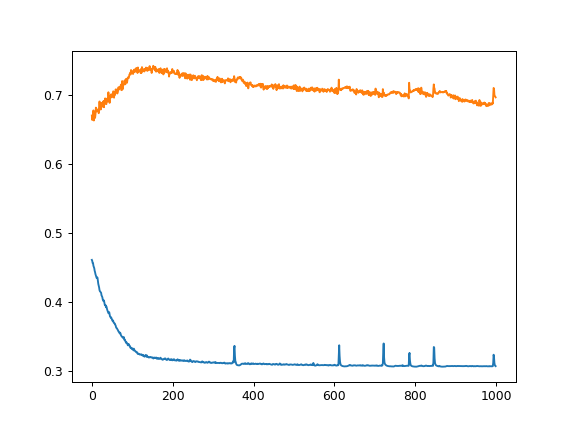

In [33]:
plt.figure()
plt.plot(history.epoch, history.history["loss"], label='Train Loss')
plt.plot(history.epoch, history.history["val_loss"], label='Vali Loss')

In [34]:
decoder_in = np.zeros((x_train.shape[0],1,n_a))
evalu_test = model.evaluate(x=[x_train,decoder_in], y=y_train)
decoder_in = np.zeros((x_val.shape[0],1,n_a))
evalu_val = model.evaluate(x=[x_val,decoder_in], y=y_val)
print('Test Error: '+ str(evalu_test))
print('Val  Error: '+ str(evalu_val))

912/912 [==============================] - 0s 121us/step
Test Error: [0.30656574020216015, 0.985755654393465]
Val  Error: [0.6663678121148494, 0.7361111065797639]


### Visualization

In [50]:
data_set = (x_train, y_train)
indexes = np.random.randint(0,data_set[0].shape[0], size=1)
x_in = data_set[0][indexes,:,:]
decoder_in = np.zeros((x_in.shape[0],1,n_a))
y_true = data_set[1][indexes,:,:]
y_pred = model.predict(x=[x_in,decoder_in])
y_pred_denorm = denormalize_data(y_pred, x_norm_param)
print('X:')
print(denormalize_data(x_in,x_norm_param))
print('Y:')
print(denormalize_data(y_true,x_norm_param))
print('LSTM Out:')
print(y_pred)
print('Y pred:')
print(y_pred_denorm)

X:
[[[-0.00504428  0.1397    ]
  [-0.00135183  0.1428    ]
  [-0.0023672   0.1544    ]
  [-0.01492538  0.1666    ]
  [ 0.00034374  0.1592    ]
  [-0.00309752  0.1624    ]
  [ 0.00448838  0.1492    ]
  [ 0.01065716  0.1472    ]
  [ 0.01496599  0.1355    ]
  [ 0.00134047  0.1451    ]]]
Y:
[[[ 0.00334568  0.149     ]
  [ 0.00433565  0.1332    ]
  [-0.00199164  0.1476    ]]]
LSTM Out:
[[[ 0.2528681  -0.5908135 ]
  [ 0.3418734  -0.78524613]
  [-0.21405752 -0.6141538 ]]]
Y pred:
[[[ 0.00338144  0.14900089]
  [ 0.00442499  0.13316257]
  [-0.00209304  0.14709961]]]


<IPython.core.display.Javascript object>


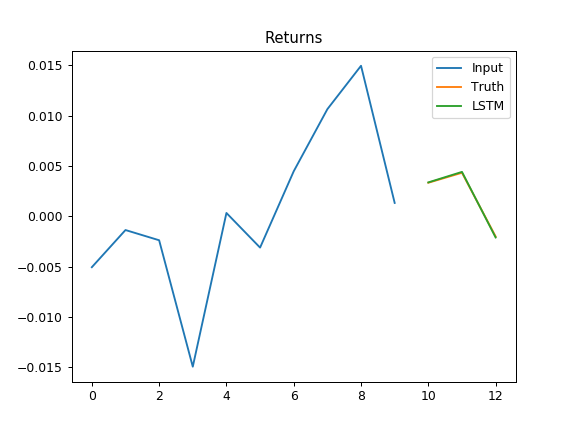

<IPython.core.display.Javascript object>


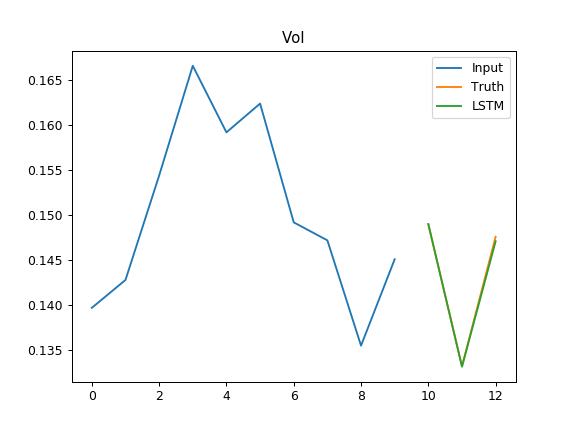

In [51]:
x_in_returns = denormalize_data(x_in,x_norm_param)[:,:,0].transpose()
x_in_vol = denormalize_data(x_in,x_norm_param)[:,:,1].transpose()
y_true_returns = denormalize_data(y_true,x_norm_param)[:,:,0].transpose()
y_true_vol = denormalize_data(y_true,x_norm_param)[:,:,1].transpose()
y_pred_returns = denormalize_data(y_pred,x_norm_param)[:,:,0].transpose()
y_pred_vol = denormalize_data(y_pred,x_norm_param)[:,:,1].transpose()
plt.figure()
plt.plot(range(0,T_x), x_in_returns, label='Input')
plt.plot(range(T_x, T_x+T_y), y_true_returns, label='Truth')
plt.plot(range(T_x, T_x+T_y), y_pred_returns, label='LSTM')
plt.title('Returns')
plt.legend()

plt.figure()
plt.plot(range(0,T_x), x_in_vol, label='Input')
plt.plot(range(T_x, T_x+T_y), y_true_vol, label='Truth')
plt.plot(range(T_x, T_x+T_y), y_pred_vol, label='LSTM')
plt.title('Vol')
plt.legend()

## SNIPPETS

### Norm - Denorm Check

In [ ]:
a, b , m = gen_dataset(T_x,T_y,T_stride,retvol_table)
x, x_norm_param = normalize_data(a)
y, _ = normalize_data(b, x_norm_param)
x = denormalize_data(x, x_norm_param)
y = denormalize_data(y, x_norm_param)

plt.figure()
plt.hist((b-y).flatten(), 100)

In [ ]:
class PlotHistory(keras.callbacks.History):
    def on_train_begin(self, logs=None):
        super().on_train_begin(logs)
        self.fig = plt.figure()
        self.axes = plt.subplot(111)
        self.trainloss_line, = self.axes.plot([],[], label='Train Loss')
        self.fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1,right=0.85, wspace=0, hspace=0) 
        self.fig.canvas.draw()
        
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        self.trainloss_line.set_data(self.epoch, self.history["loss"])
        self.axes.relim()
        self.fig.canvas.draw()
# Update of plot does not properly work